In [1]:
%load_ext autoreload
%autoreload 2
from Network import Network
from FrankWolf import *
from EntropyMaximisation import *
from RemoveBraess import *

import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from graph_tool.centrality import betweenness

from IPython.display import display_markdown

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


# Identification of Braess links in traffic Networks - Finding braess links

In this notebook, we reuse the previous results to finally test our hypothese :

$$
x_{ij}^{UE,\ od} > 0 \textrm{ and } x_{ij}^{SO,\ od} = 0 \Rightarrow \textrm{Link (i, j) is a Braess link for OD (o, d)}
$$

Where :
- $x_{ij}^{UE/SO,\ od}$ represent the flow on the link from node $i$ to node $j$, that is caused by the trafic going from origin $o$ to destination $d$, at User Equilibrium, respectively at System Optimum

In [2]:
net = Network("SiouxFalls")
UE_OD_flows = net.load_flow("UE_OD_flows")
SO_OD_flows = net.load_flow("SO_OD_flows")

sns.set_theme("paper", "darkgrid", font="serif")

Text(0.5, 0, 'OD link flow values (log scale)')

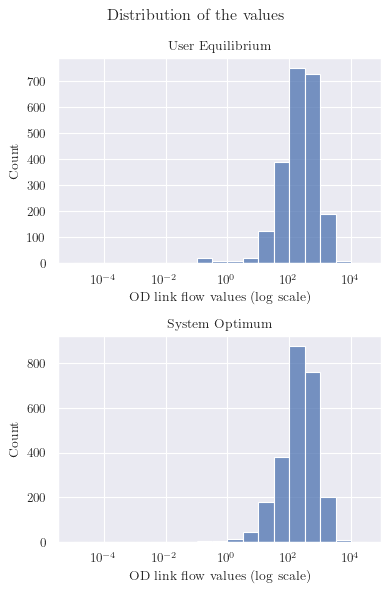

In [3]:
# Visualisation
fig, axes = plt.subplots(2, 1, layout = "tight", figsize=(4, 6))
sns.histplot(x=UE_OD_flows[(UE_OD_flows>0)], bins=np.arange(-5, 5, 0.5), log_scale=True, ax=axes[0])
plt.suptitle("Distribution of the values")
axes[0].set_title("User Equilibrium")
axes[0].set_xlabel("OD link flow values (log scale)")
sns.histplot(x=SO_OD_flows[(SO_OD_flows>0)], bins=np.arange(-5, 5, 0.5), log_scale=True, ax=axes[1])
axes[1].set_title("System Optimum")
axes[1].set_xlabel("OD link flow values (log scale)")

## A note on threshold

Previously, we applied thresholds to remove near-zero values and consider as null. Here, we will not apply here such a threshold at first, firstly because, as a result from the previous thresholds, OD-based flows have a value of at least 0.1, but also because we will later on consider the magnitude of the UE OD-based flow as a potential explaining variable, which if it shows a different component for the smaller values would indicates that applying a threshold would be usefull.

## Selecting suspicious links

In [4]:
mask = (UE_OD_flows > 0) & (SO_OD_flows == 0)
print(f"Total number of links identified : {mask.sum()}")
print(f"ODs concerned : {(mask.sum(axis=2)>0).sum()} / {(net.trips>0).sum()}")


Total number of links identified : 260
ODs concerned : 68 / 528


### Analyse the ODs concerned :

Let's have a look at which ODs appear most in our mask

In [5]:
# Analyse OD concerned :
links_per_OD = pd.DataFrame(mask.sum(axis=2))
links_per_OD.index += 1
links_per_OD.columns += 1
links_per_OD.index.name = "Origin"
links_per_OD.columns.name = "Destination"
s = links_per_OD.style \
            .set_caption("Number of links concerned, per OD") \
            .background_gradient(axis=None) \
            .map(lambda x: 'opacity: 20%;' if x==0 else '')

# print(s.to_latex(convert_css=True))
s

Destination,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
Origin,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0
2,0,0,0,0,2,0,0,0,2,2,0,0,0,0,2,0,7,0,6,0,0,6,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,5,0,3,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,3,0
7,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0


#### Analyse OD 13 - 19 (one of the OD that has the most identified links)

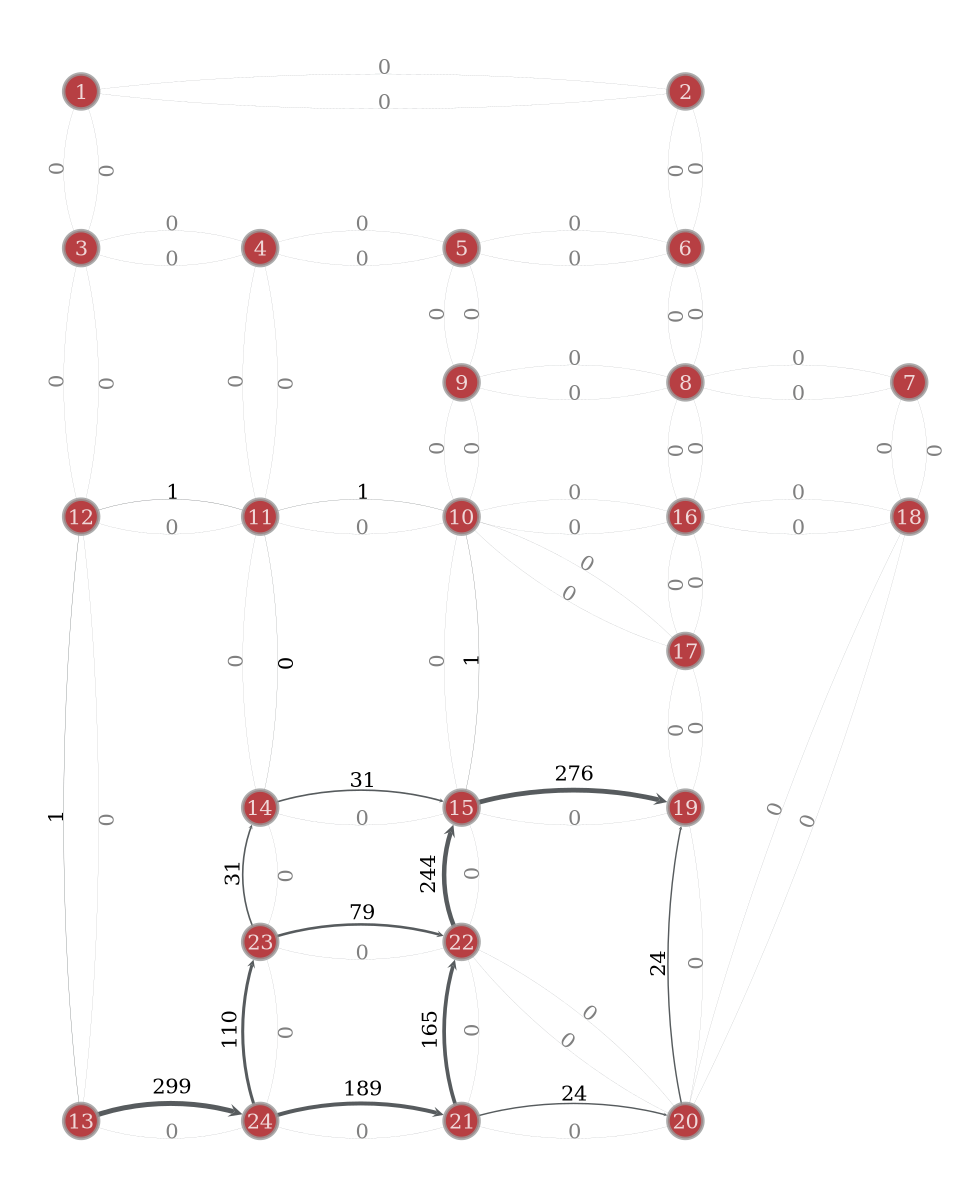

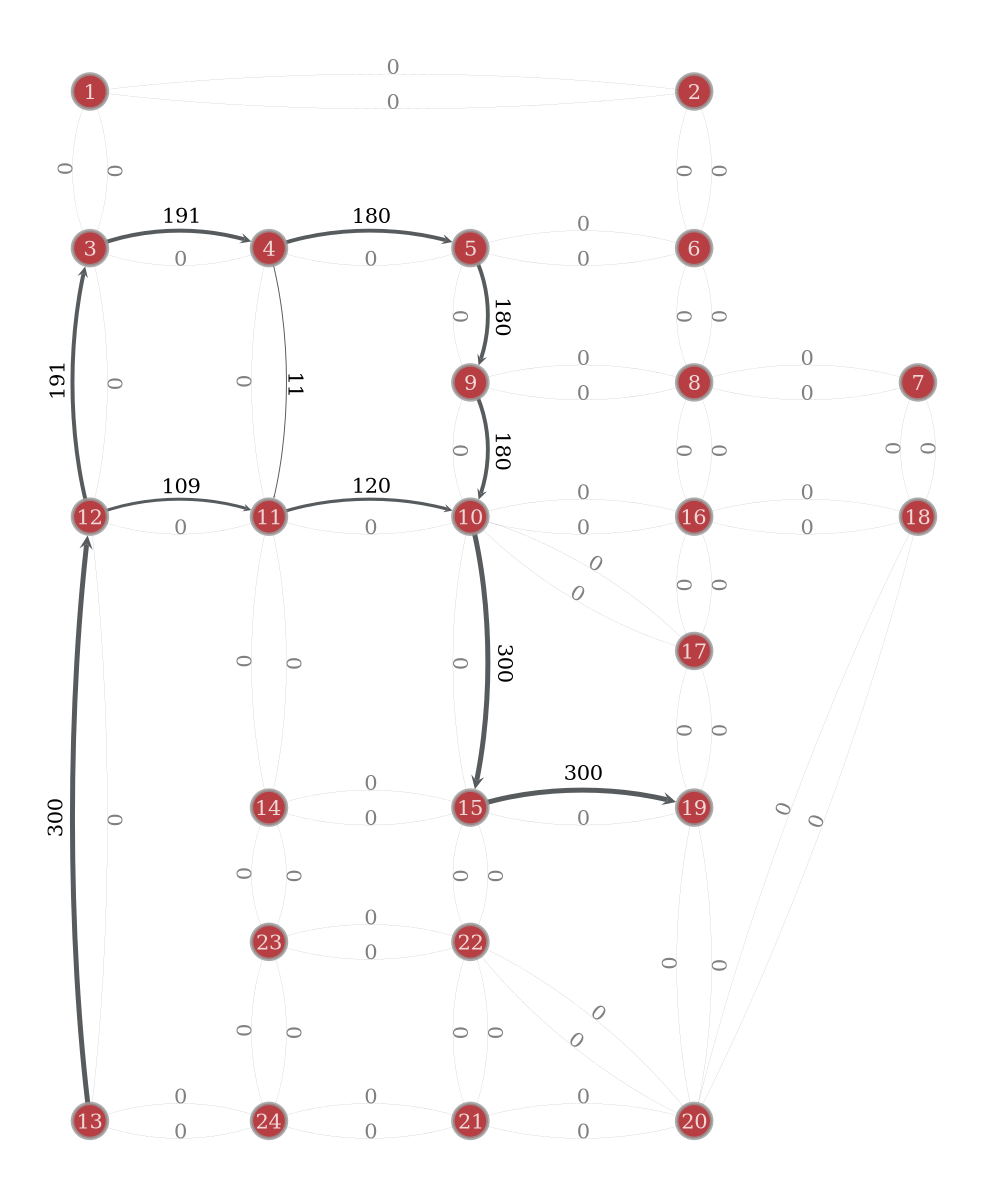

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f497b0a57c0, at 0x7f4972769fd0>

In [6]:
net.draw(flows_by_OD = UE_OD_flows, o = 13, d = 19, output="figs/UE_flows_13_19.pdf")
net.draw(flows_by_OD = UE_OD_flows, o = 13, d = 19)

net.draw(flows_by_OD = SO_OD_flows, o = 13, d = 19, output="figs/SO_flows_13_19.pdf")
net.draw(flows_by_OD = SO_OD_flows, o = 13, d = 19)

#### Ban the links concerned for each OD

In [ ]:
# For each OD (where > 0), ban all concerned links to see the impact on the total travel time
try_removing_braess(net, mask, save_folder="files/masked", export_folder="exports/masked")

### Analyse the most common links

Link number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76
Number of ODs,1,0,1,8,0,0,0,0,0,3,0,4,1,8,4,5,5,6,5,5,0,1,1,0,6,6,1,1,5,0,3,1,1,12,0,1,0,0,4,12,9,9,1,9,2,5,1,5,1,1,0,1,3,6,1,5,2,3,8,5,8,4,1,4,5,4,5,1,5,4,9,4,5,4,4,5


Link number,40,34,41,44,71,42,14,4,61,59,26,54,25,18,29,65,76,60,73,67,69,48,56,20,19,16,46,17,12,62,75,66,64,15,72,70,74,39,58,53,31,10,57,45,1,3,50,36,49,47,43,68,22,23,33,32,28,27,55,52,63,13,5,7,9,8,35,37,51,38,6,30,21,24,11,2
Number of ODs,12,12,9,9,9,9,8,8,8,8,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,3,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


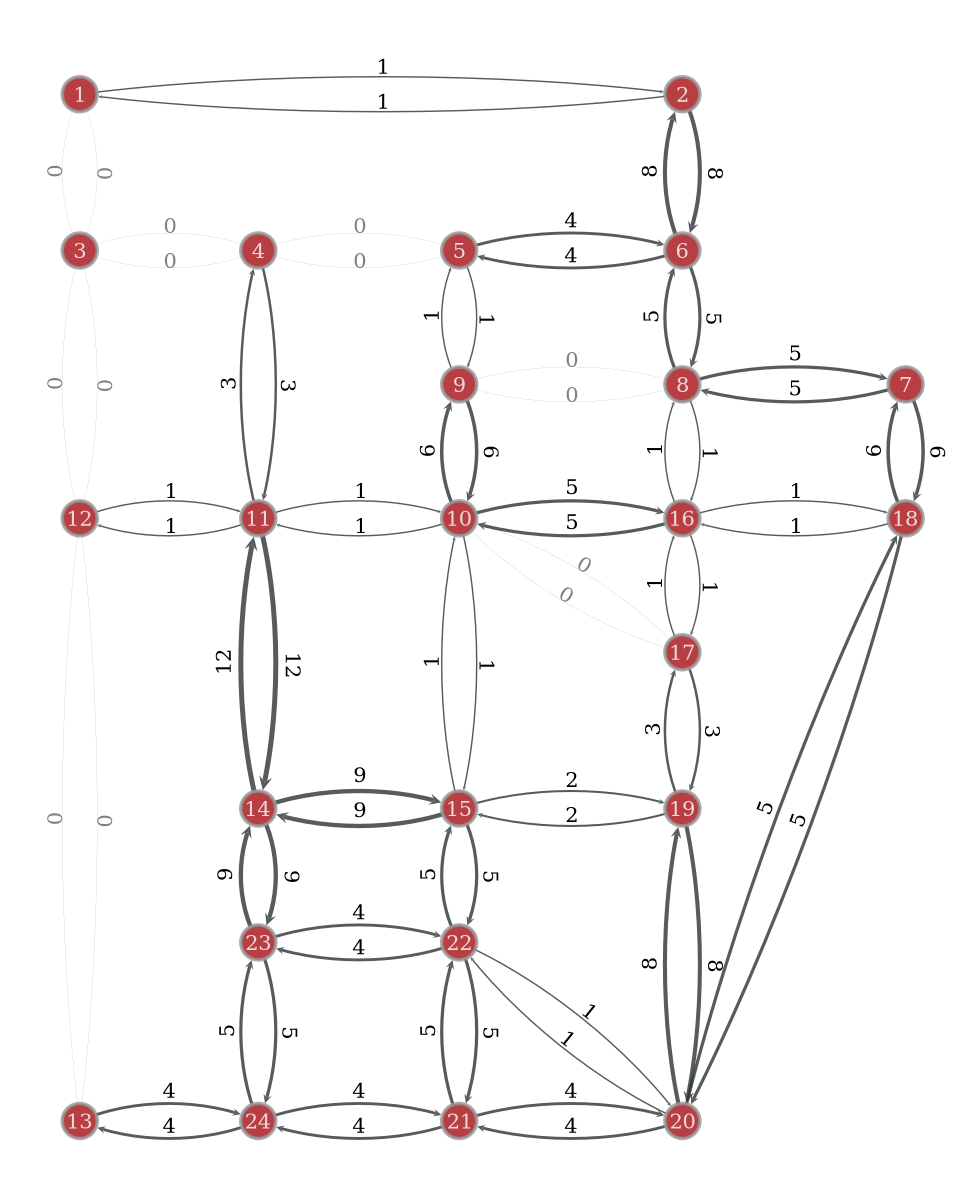

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f497b0a57c0, at 0x7f4971ffb530>

In [8]:
# Analyse links concerned (most common links):
OD_per_links = pd.DataFrame(mask.sum(axis=0).sum(axis=0), columns=["Number of ODs"]).T

OD_per_links.columns += 1
OD_per_links.columns.name = "Link number"

s= OD_per_links.style \
            .set_caption("Number of OD concerned, per link") \
            .background_gradient(axis=None) \
            .map(lambda x: 'opacity: 20%;' if x==0 else '')

display(s)

s = OD_per_links.sort_values("Number of ODs", axis = 1, ascending=False) \
            .style \
            .set_caption("Number of OD concerned, per link, sorted") \
            .background_gradient(axis=None) \
            .map(lambda x: 'opacity: 20%;' if x==0 else '')
display(s)

net.draw(False, net.new_edge_property("float", OD_per_links.loc["Number of ODs"]), output = "figs/links_n_id.pdf")
net.draw(False, net.new_edge_property("float", OD_per_links.loc["Number of ODs"]))

#### Analyse link 34 (one of the most common link)

In [9]:
# Let's have a look at link 34 (one of the two that appears most often) : from node 11 to node 14
print("ODs that have flow passing through link 34 at UE but not at SO :")
print(", ".join([f"{o+1:2d}->{d+1:2d}" for o, d in zip(*np.nonzero(mask[:, :, 33]))]))

print("ODs that have flow passing through link 34 at UE but also at SO :")
print(", ".join([f"{o+1:2d}->{d+1:2d}" for o, d in zip(*np.nonzero(~mask[:,:,33] & (UE_OD_flows[:, :, 33] > 0)))]))

ODs that have flow passing through link 34 at UE but not at SO :
 4->23,  5->23,  6->23, 11->15, 11->19, 11->20, 11->21, 11->22, 12->15, 12->19, 13->15, 13->19
ODs that have flow passing through link 34 at UE but also at SO :
 1->14,  2->14,  3->14,  4->14,  5->14,  6->14,  9->14,  9->23, 10->14, 10->23, 10->24, 11->14, 11->23, 11->24, 12->14, 13->14


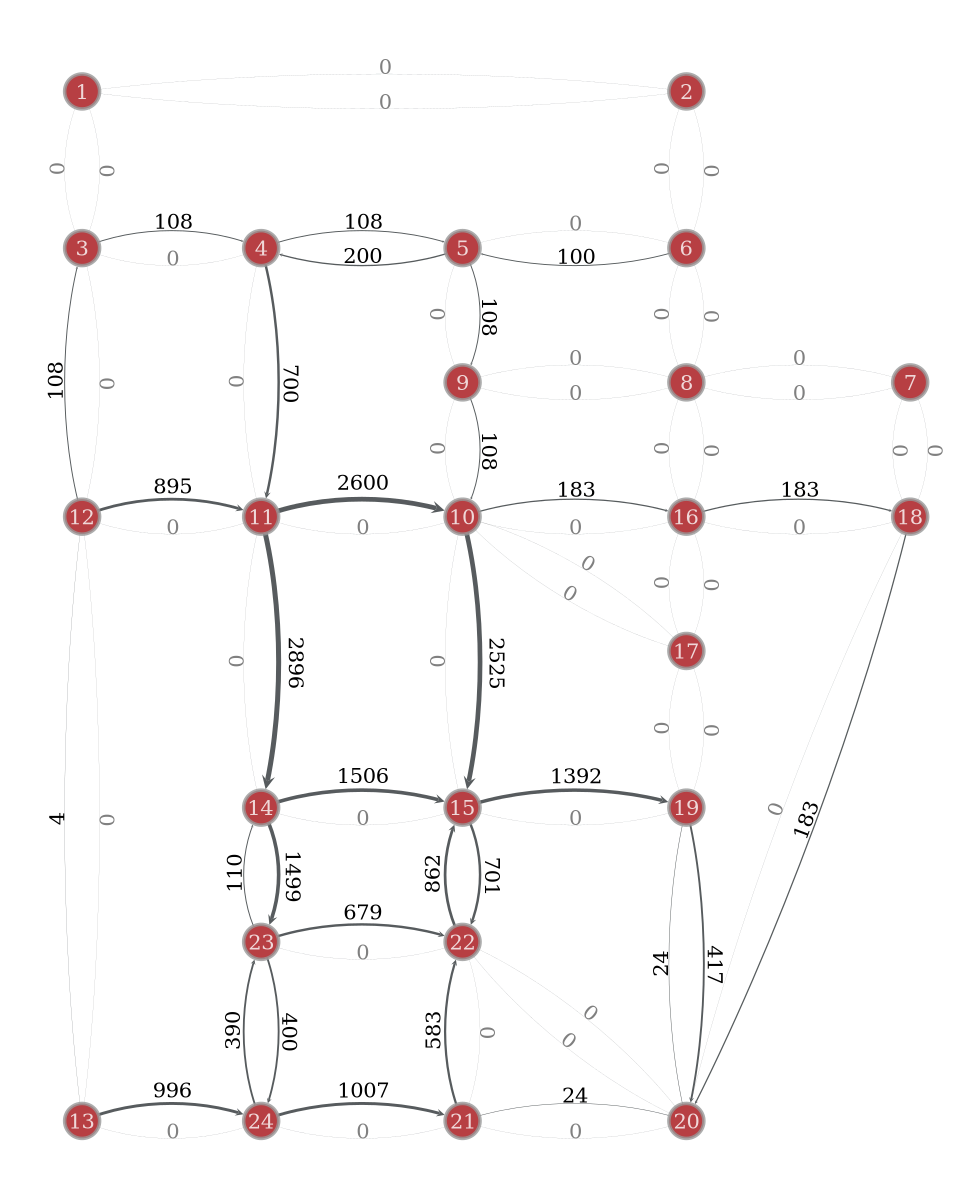

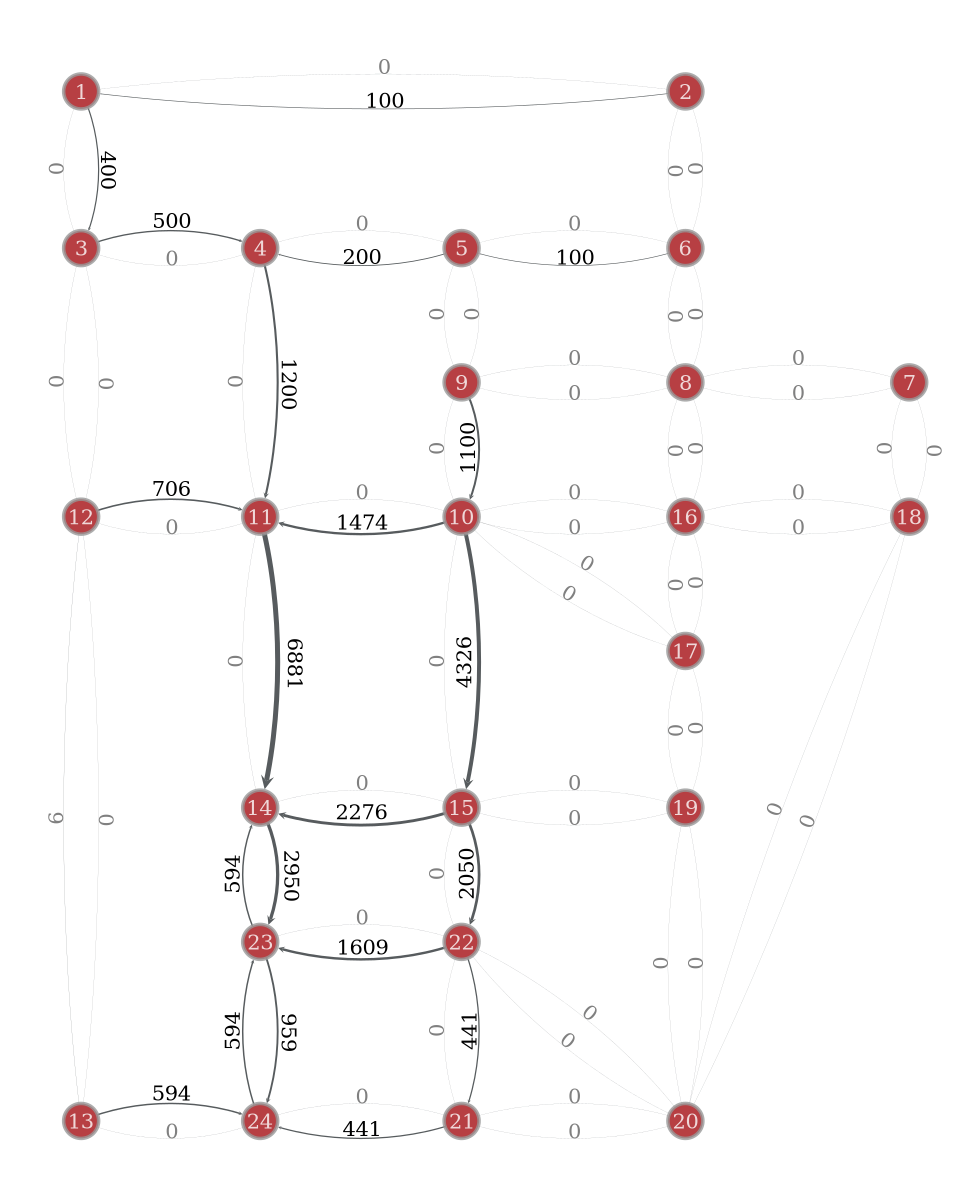

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f497b0a57c0, at 0x7f4971ffb0b0>

In [10]:
flow_masked_link_34 = UE_OD_flows[*np.nonzero(mask[:, :, 33])].sum(axis=0)
net.draw(flows=net.new_edge_property("float", vals=flow_masked_link_34))

flow_not_masked_link_34 = UE_OD_flows[*np.nonzero(~mask[:,:,33] & (UE_OD_flows[:, :, 33] > 0))].sum(axis=0)
net.draw(flows=net.new_edge_property("float", vals=flow_not_masked_link_34))

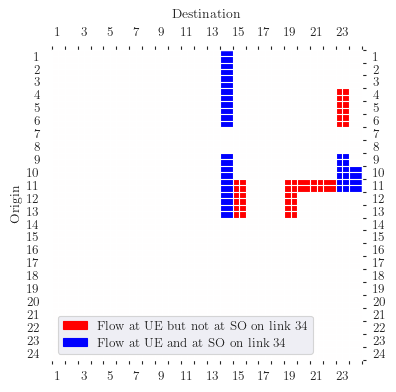

In [11]:
matrix = np.zeros(mask.shape[:2])
matrix[mask[:, :, 33]] = 1
matrix[(~mask[:,:,33]) & (UE_OD_flows[:, :, 33] > 0)] = -1

im = plt.matshow(matrix, cmap="bwr", extent = [0.5, 24.5, 24.5, 0.5])
# Legend
get_c = lambda x: im.cmap(im.norm(x))
patches = [ mpatches.Patch(color=get_c(1), label="Flow at UE but not at SO on link 34"), mpatches.Patch(color=get_c(-1), label="Flow at UE and at SO on link 34")]
plt.legend(handles=patches, loc="lower left")

plt.xticks(np.arange(0.5, 25), minor=True)
plt.yticks(np.arange(0.5, 25), minor=True)
plt.yticks(np.arange(1, 25))
plt.xticks(np.arange(1, 25, 2))
plt.grid(which="minor")
plt.ylabel("Origin")
plt.title("Destination")
plt.gcf().set_size_inches(4, 4)

im.axes.tick_params(left = False, top = False, bottom=False, labelright=True, labelbottom = True, which="major")
im.axes.tick_params(right = True, bottom=True, which="minor")

plt.savefig("figs/OD_pair_14.pgf", bbox_inches="tight")

#### Ban most concerned links from the network (for all OD)

In [14]:
# For each concerned link, ban it from the network (so for all OD)
links = OD_per_links[OD_per_links>0].dropna(axis=1).columns
remove_all_OD(net, links, save_folder="files/masked", export_folder="exports/masked")

1052it [14:34,  1.20it/s, Relative error=9.99e-05]
1117it [14:45,  1.26it/s, Relative error=9.67e-05]
952it [13:35,  1.17it/s, Relative error=9.92e-05]]
728it [09:24,  1.29it/s, Relative error=9.99e-05]]
658it [08:05,  1.36it/s, Relative error=9.67e-05]]
1181it [14:03,  1.40it/s, Relative error=8.94e-05]t]
873it [08:40,  1.68it/s, Relative error=9.99e-05]it]
1253it [12:53,  1.62it/s, Relative error=9.97e-05]] 
1136it [12:33,  1.51it/s, Relative error=9.77e-05]t]
1092it [12:08,  1.50it/s, Relative error=9.39e-05]t]
1233it [13:53,  1.48it/s, Relative error=9.78e-05]it]
1127it [12:51,  1.46it/s, Relative error=9.87e-05]it]
1000it [10:53,  1.53it/s, Relative error=9.68e-05]it]
680it [07:38,  1.48it/s, Relative error=8.69e-05]it] 
1026it [12:30,  1.37it/s, Relative error=9.20e-05]t]
1132it [12:50,  1.47it/s, Relative error=9.41e-05]t]
597it [06:40,  1.49it/s, Relative error=9.18e-05]it]
813it [09:31,  1.42it/s, Relative error=9.64e-05]it]
1575it [18:20,  1.43it/s, Relative error=9.69e-05]t]

## Analyse the relationship between link and OD

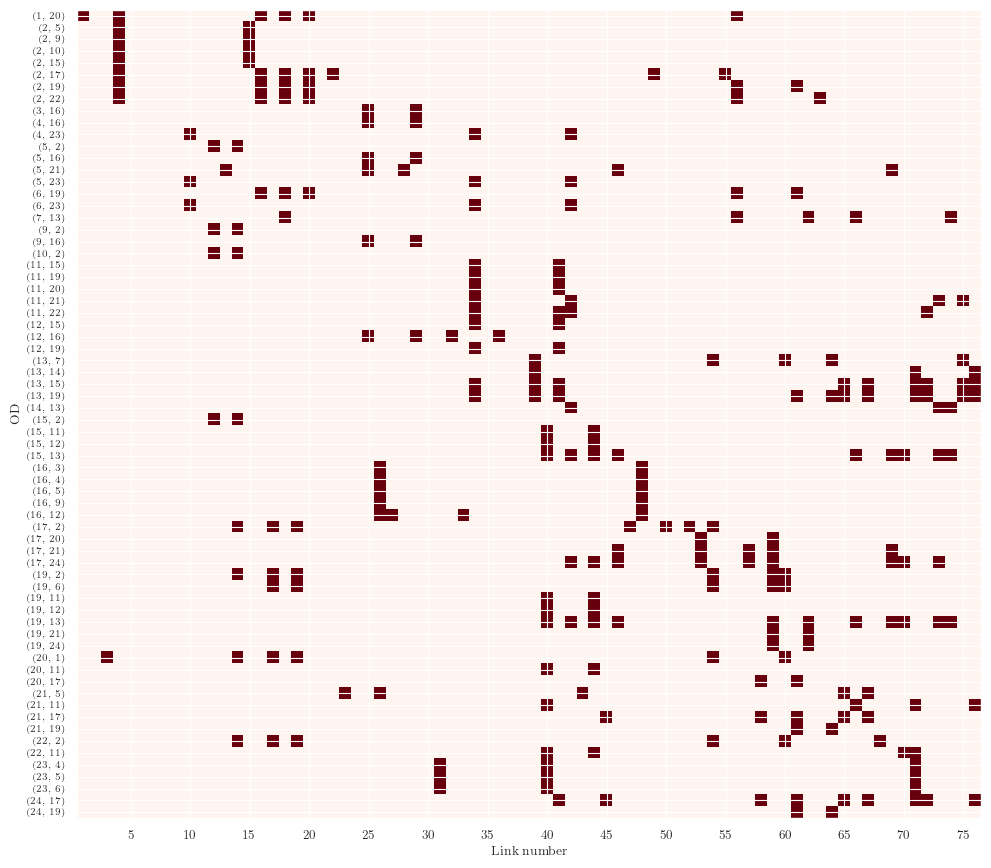

In [12]:
# See which link is concerned for which OD :
plt.figure(figsize=(10,10))
im = plt.imshow(mask[*np.nonzero(mask.sum(axis=2))], cmap="Reds")
plt.xticks(np.arange(4, mask.shape[-1], 5), np.arange(4, mask.shape[-1], 5)+1)
plt.yticks(np.arange((mask.sum(axis=2)>0).sum()), list(zip(*[i+1 for i in np.nonzero(mask.sum(axis=2))])), size="x-small")
im.axes.set_xlabel("Link number")
im.axes.set_ylabel("OD")
#plt.ylabel("(o, d)")
plt.tight_layout()
plt.show()

Text(954.459111124083, 0.5, 'OD')

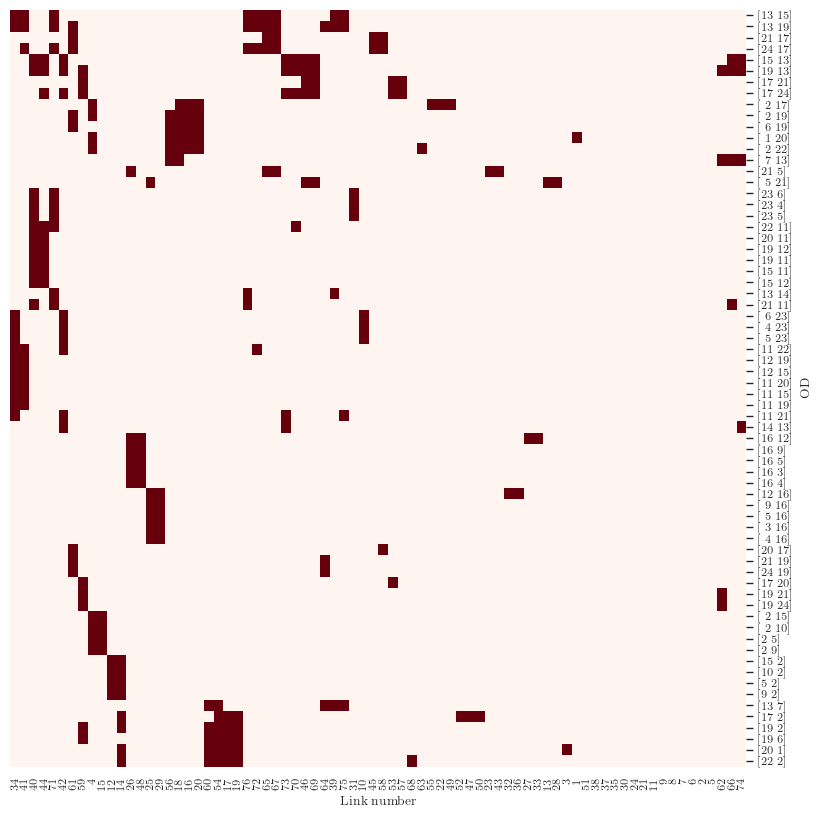

In [13]:
# See which link is concerned for which OD :
cg = sns.clustermap(mask[*np.nonzero(mask.sum(axis=2))], cmap="Reds", cbar=False, yticklabels=list(zip(*[i+1 for i in np.nonzero(mask.sum(axis=2))])), xticklabels = np.arange(mask.shape[-1])+1)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_cbar.set_visible(False)
cg.ax_heatmap.tick_params(labelsize="small")
cg.ax_heatmap.set_xlabel("Link number")
cg.ax_heatmap.set_ylabel("OD")
#plt.yticks(np.arange(0.5, (mask.sum(axis=2)>0).sum()), zip(*np.nonzero(mask.sum(axis=2))), size="x-small", rotation=0)
#plt.ylabel("(o, d)")
#plt.tight_layout()
#plt.show()

## Test the hypothese

In order to test the hypothesis, we will compare the total travel time after banning the links concerned for the ODs concerned. We will also take a look at potential explanatory variables

### After banning, for each OD, all concerned links

We will explore the following explanatory variables that could explain the difference in improvement for each OD :
- Demand for that OD
- Number of removed links (= # of identified link for that OD)
- Flow at UE for the given OD on the links (min, mean, max)
- Percentage of the OD UE paths impacted by the ban
- Percentage of the OD demand impacted by the ban (using the paths)
- Betweeness centrality of the links [min, mean, max]
- Total flow on the links impacted (all OD), (min, mean, max)

This set of variables explore both the importance of the identified links for the given OD and in the general network, as well as the importance of the OD to the network. However, this only include a few topological measures (betweeness centrality, the total flow could be considered one as well) but further research into centrality measures and their potential as explanatory variables is probably needed.

In [14]:
# Get the paths
# UE  
flows_by_o = net.load_flow("UE_flows_by_o_filtered")

_, paths = get_OD_flows(net, net.trips, flows_by_origin=flows_by_o, flow_limit = 0.1, return_paths=True)

/home/ars/Braess-Links-Identification2/Braess-Links-Identification/EntropyMaximisation.py:163: RuntimeWarning: invalid value encountered in divide
  psi_r_ij[:, in_edge_indices] = np.where(eta_rj[:,[j]] > 0, x_a[:, in_edge_indices]/eta_rj[:,[j]], 0)
100%|██████████| 24/24 [01:18<00:00,  3.28s/it]


In [15]:
# To compare, compute total travel time without banning links.
flows = net.load_flow(f"fw_p4", folder="files/precision", dim=1)
original_ttt = float(compute_total_travel_time(net, flows))
print("original total travel time :", original_ttt)

# Compute the betweeness centrality
_, edge_betweenness = betweenness(net, )

records = {}
for o, d in tqdm(list(zip(*np.where(mask.sum(axis=2)>0)))):
    flows = net.load_flow(f"o{o}d{d}", dim=1, folder="files/masked")
    ttt = float(compute_total_travel_time(net, flows))

    # Get the impact on the paths
    od_paths = paths[o,d]
    impacted_paths = 0
    impacted_flow = 0.0
    for path, path_flow in od_paths:
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        if (net.get_edge_mask(path_edges) * mask[o, d]).sum() > 0:
            impacted_paths +=1
            impacted_flow += path_flow
    
    records[o+1,d+1] = {
        "Banned links": ", ".join((np.nonzero(mask[o,d])[0]+1).astype(str)),
        "Total travel time": ttt,
        "Improvement": original_ttt - ttt,
        "Relative improvement": (original_ttt - ttt) / original_ttt,
        "Has improved" : (original_ttt - ttt) > 0,
        "OD_demand" : net.trips[o,d],
        "Improvement normalised": float(original_ttt - ttt)/net.trips[o,d],
        "N removed links": mask[o,d].sum(),
        "UE_flows_on_banned_links": UE_OD_flows[o,d,mask[o,d]],
        "min_UE_flow_on_banned_links" : UE_OD_flows[o,d,mask[o,d]].min(),
        "mean_UE_flow_on_banned_links" : UE_OD_flows[o,d,mask[o,d]].mean(),
        "max_UE_flow_on_banned_links" : UE_OD_flows[o,d,mask[o,d]].max(),
        "percentage_OD_paths_impacted": impacted_paths / len(od_paths),
        "percentage_OD_demand_impacted" : impacted_flow / net.trips[o, d],
        "betweenness_centrality" : edge_betweenness.a[mask[o, d]],
        "min_betweenness_centrality" : float(edge_betweenness.a[mask[o, d]].min()),
        "mean_betweenness_centrality" : float(edge_betweenness.a[mask[o, d]].mean()),
        "max_betweenness_centrality" : float(edge_betweenness.a[mask[o, d]].max()),
        "total_flows_on_banned_links": flows.a[mask[o,d]],
        "min_total_flow_on_banned_links" : float(flows.a[mask[o,d]].min()),
        "mean_total_flow_on_banned_links" : float(flows.a[mask[o,d]].mean()),
        "max_total_flow_on_banned_links" : float(flows.a[mask[o,d]].max()),
    }
df = pd.DataFrame.from_dict(records, orient="index")
df.index.set_names(["o", "d"], inplace=True)
df

original total travel time : 7479625.830083258


100%|██████████| 68/68 [00:00<00:00, 391.37it/s]


Banned links  Total travel time  Improvement  \
o  d                                                                        
1  20                1, 4, 16, 18, 20, 56       7.480691e+06 -1065.345130   
2  5                                4, 15       7.479804e+06  -178.651005   
   9                                4, 15       7.479692e+06   -66.199526   
   10                               4, 15       7.474682e+06  4943.715854   
   15                               4, 15       7.479504e+06   122.027883   
...                                   ...                ...          ...   
23 4                           31, 40, 71       7.474923e+06  4702.776264   
   5                           31, 40, 71       7.478584e+06  1041.678513   
   6                           31, 40, 71       7.478752e+06   873.477596   
24 17  41, 45, 58, 61, 65, 67, 71, 72, 76       7.479785e+06  -158.750871   
   19                              61, 64       7.479588e+06    38.187464   

       Relative improvement  Has improved  OD_demand  Improvement normalised  \
o  d                                                                           
1  20             -0.000142         False      300.0               -3.551150   
2  5              -0.000024         False      100.0               -1.786510   
   9              -0.000009         False      200.0               -0.330998   
   10              0.000661          True      600.0                8.239526   
   15              0.000016          True      100.0                1.220279   
...                     ...           ...        ...                     ...   
23 4               0.000629          True      500.0                9.405553   
   5               0.000139          True      100.0               10.416785   
   6               0.000117          True      100.0                8.734776   
24 17             -0.000021         False      300.0               -0.529170   
   19              0.000005          True      100.0                0.381875   

       N removed links                           UE_flows_on_banned_links  \
o  d                                                                        
1  20                6         [300.0, 300.0, 300.0, 300.0, 300.0, 300.0]   
2  5                 2             [83.54049139424346, 83.54049139424346]   
   9                 2           [167.08098278848692, 167.08098278848692]   
   10                2             [501.2429483654608, 501.2429483654608]   
   15                2             [83.53951641777103, 83.53951641777103]   
...                ...                                                ...   
23 4                 3  [499.97890760522034, 499.97890760522034, 499.9...   
   5                 3  [99.99578152104407, 99.99578152104407, 99.9957...   
   6                 3  [99.99460756953412, 99.99460756953412, 99.9946...   
24 17                9  [17.003299676926844, 150.15725075783524, 163.4...   
   19                2             [8.141796408282557, 8.141796408282557]   

       min_UE_flow_on_banned_links  ...  percentage_OD_paths_impacted  \
o  d                                ...                                 
1  20                   300.000000  ...                          1.00   
2  5                     83.540491  ...                          0.50   
   9                    167.080983  ...                          0.50   
   10                   501.242948  ...                          0.50   
   15                    83.539516  ...                          0.50   
...                            ...  ...                           ...   
23 4                    499.978908  ...                          1.00   
   5                     99.995782  ...                          1.00   
   6                     99.994608  ...                          1.00   
24 17                    13.309100  ...                          0.80   
   19                     8.141796  ...                          0.25   

       percentage_OD_demand_impact

In [16]:
# For comparison, we compute the travel time of frankwolf with precision 10^-6, to see if the precision has an impact on the travel time
flows_p6 = net.load_flow(f"fw_p6", folder="files/precision", dim=1)
ttt_p6 = float(compute_total_travel_time(net, flows_p6))
print("Difference in travel time between precision 1e-4 and 1e-6 : ", ttt_p6 - original_ttt, f"({(ttt_p6 - original_ttt)/original_ttt*100:.3f} % of the original travel time)")
proportion_in_this_scale = (df["Improvement"] < (ttt_p6 - original_ttt)).mean()

print(f"Percentage of results negative : \t{100*(df["Improvement"] < (0)).mean():.1f} %")
print(f"Percentage of results lower than the difference in travel time: \t{100*proportion_in_this_scale:.1f} %")


Difference in travel time between precision 1e-4 and 1e-6 :  593.7807534653693 (0.008 % of the original travel time)
Percentage of results negative : 	42.6 %
Percentage of results lower than the difference in travel time: 	58.8 %


We see that 16.2 % of the results did improve, but by less than the absolute difference in travel time from an increased precision.

#### Initial analysis

Before looking at explanatory variable, let's start with visualising the results themselves

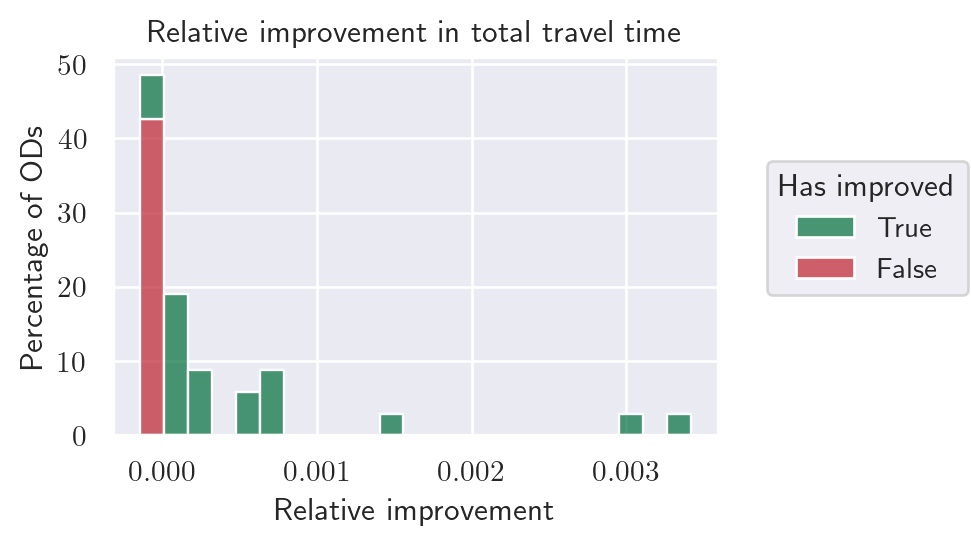

In [17]:
(
    so.Plot(data=df, color="Has improved", x="Relative improvement")
    .add(so.Bars(), so.Hist("percent"), so.Stack())
    .scale(color="blend:#006f3c,#bf212f")
    .label(y="Percentage of ODs", title="Relative improvement in total travel time")
    .layout(size=(4, 3))
    .plot()
    .save("figs/results/hist.pgf", bbox_inches="tight")
)

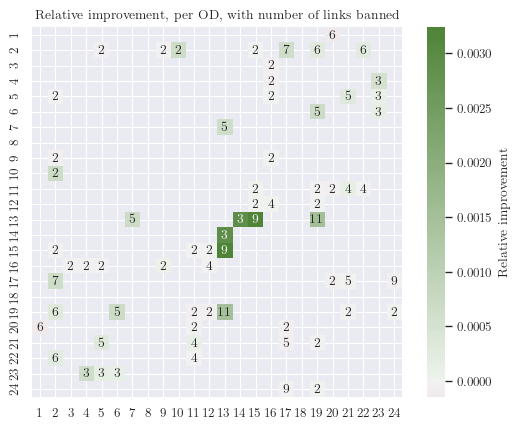

In [18]:
matrix = df.reset_index().pivot(index="o", columns="d", values="Relative improvement")
matrix = matrix.reindex(pd.RangeIndex(1,25))
matrix = matrix.reindex(pd.RangeIndex(1,25), axis=1)

matrix = matrix.to_numpy()
im = sns.heatmap(matrix,
                annot = mask.sum(axis=2),
                cmap=sns.diverging_palette(0, 120, as_cmap=True),
                cbar_kws=dict(label = "Relative improvement"),
                vmin = np.nanmin(matrix),
                center=0,
                robust=True,
                square=True,
                xticklabels = np.arange(1,25),
                yticklabels= np.arange(1,25))

plt.title("Relative improvement, per OD, with number of links banned")
plt.savefig("figs/results/OD_comparison_results.pgf", bbox_inches="tight")

#### OD demand

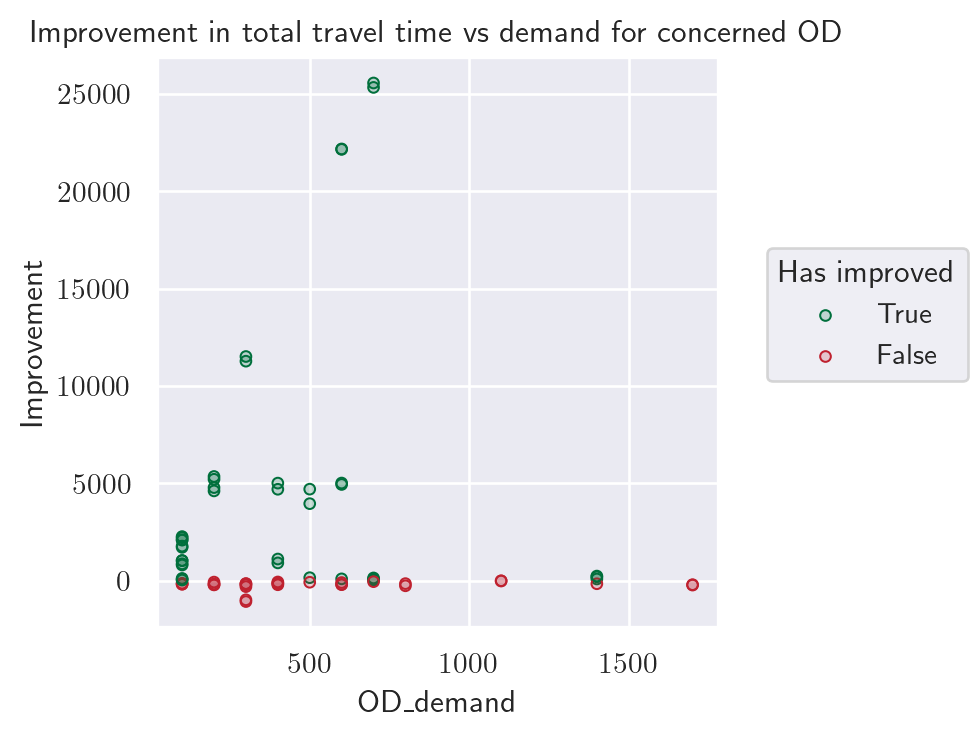

In [19]:
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Improvement")
    .add(so.Dots())
    .scale(color="blend:#006f3c,#bf212f")
    .label(title="Improvement in total travel time vs demand for concerned OD")
    .layout(size=(4, 4))
    .plot()
    .save("figs/results/OD_demand.pgf", bbox_inches = "tight")
)

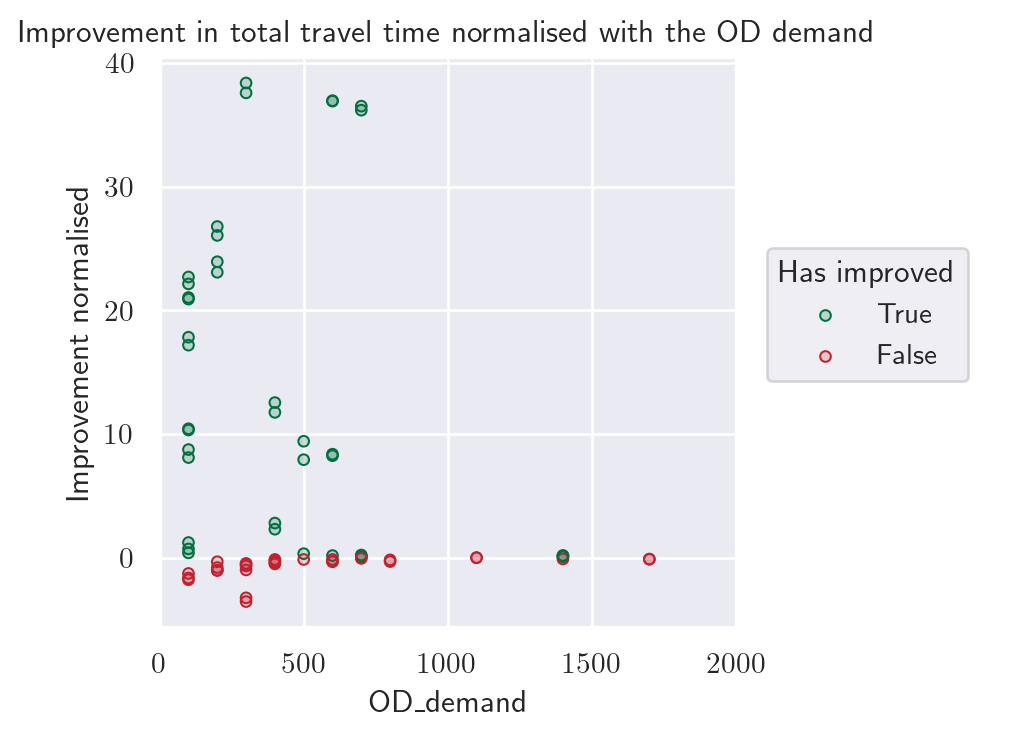

In [20]:
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Improvement normalised")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Dots())
    .limit(x=(0, 2000))
    .label(title="Improvement in total travel time normalised with the OD demand")
    .layout(size=(4, 4))
    .plot()
    .save("figs/results/OD_demand_norm.pgf", bbox_inches = "tight")
)

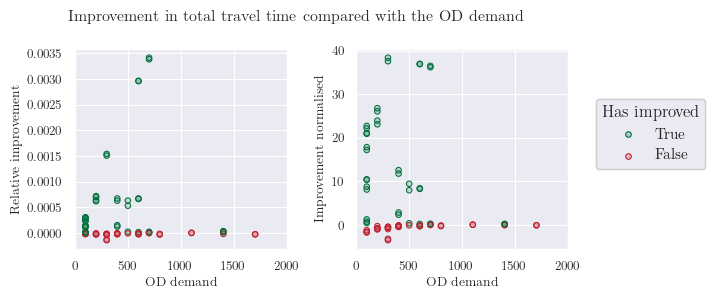

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), layout="tight")
sns.set_theme("paper", "darkgrid", font="serif")
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Relative improvement")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Dots())
    .label(x = "OD demand")
    .limit(x=(0, 2000))
    .on(ax1)
    .plot()
)
(
    so.Plot(data=df, color="Has improved", x="OD_demand", y="Improvement normalised")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Dots())
    .label(x = "OD demand")
    .limit(x=(0, 2000))
    .on(ax2)
    .plot()
)

plt.suptitle("Improvement in total travel time compared with the OD demand")
plt.savefig("figs/results/OD_demand_both.pgf", bbox_inches = "tight")

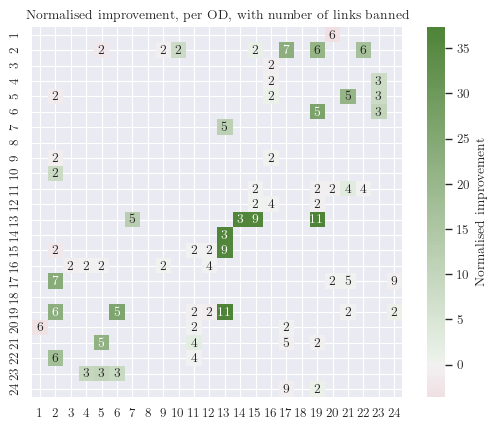

In [22]:
matrix = df.reset_index().pivot(index="o", columns="d", values="Improvement normalised")
matrix = matrix.reindex(pd.RangeIndex(1,25))
matrix = matrix.reindex(pd.RangeIndex(1,25), axis=1)

matrix = matrix.to_numpy()
im = sns.heatmap(matrix,
                annot = mask.sum(axis=2),
                cmap=sns.diverging_palette(0, 120, as_cmap=True),
                cbar_kws=dict(label = "Normalised improvement"),
                vmin = np.nanmin(matrix),
                center=0,
                robust=True,
                square=True,
                xticklabels = np.arange(1,25),
                yticklabels= np.arange(1,25))

plt.title("Normalised improvement, per OD, with number of links banned")
plt.savefig("figs/results/OD_comparison_results_norm.pgf", bbox_inches="tight")

#### Number of removed links

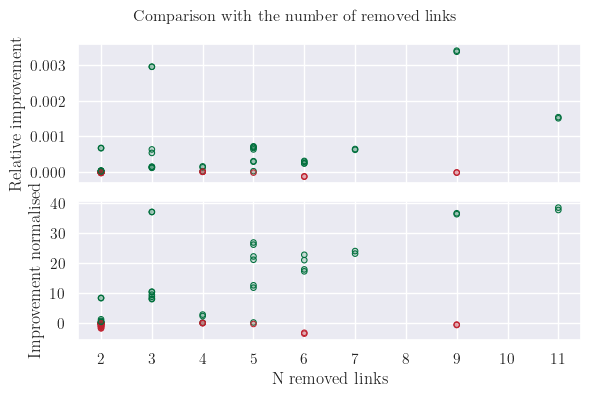

In [23]:
(
    so.Plot(data=df, color="Has improved", x="N removed links")
    .pair(y = ["Relative improvement", "Improvement normalised"])
    .scale(color="blend:#006f3c,#bf212f", x=so.Continuous().tick(every=1))
    .add(so.Dots(), legend=False)
    .layout(size=(6, 4), engine="tight")
    .plot(pyplot=True)
)
plt.suptitle("Comparison with the number of removed links")
plt.savefig("figs/results/N_removed.pgf", bbox_inches="tight")

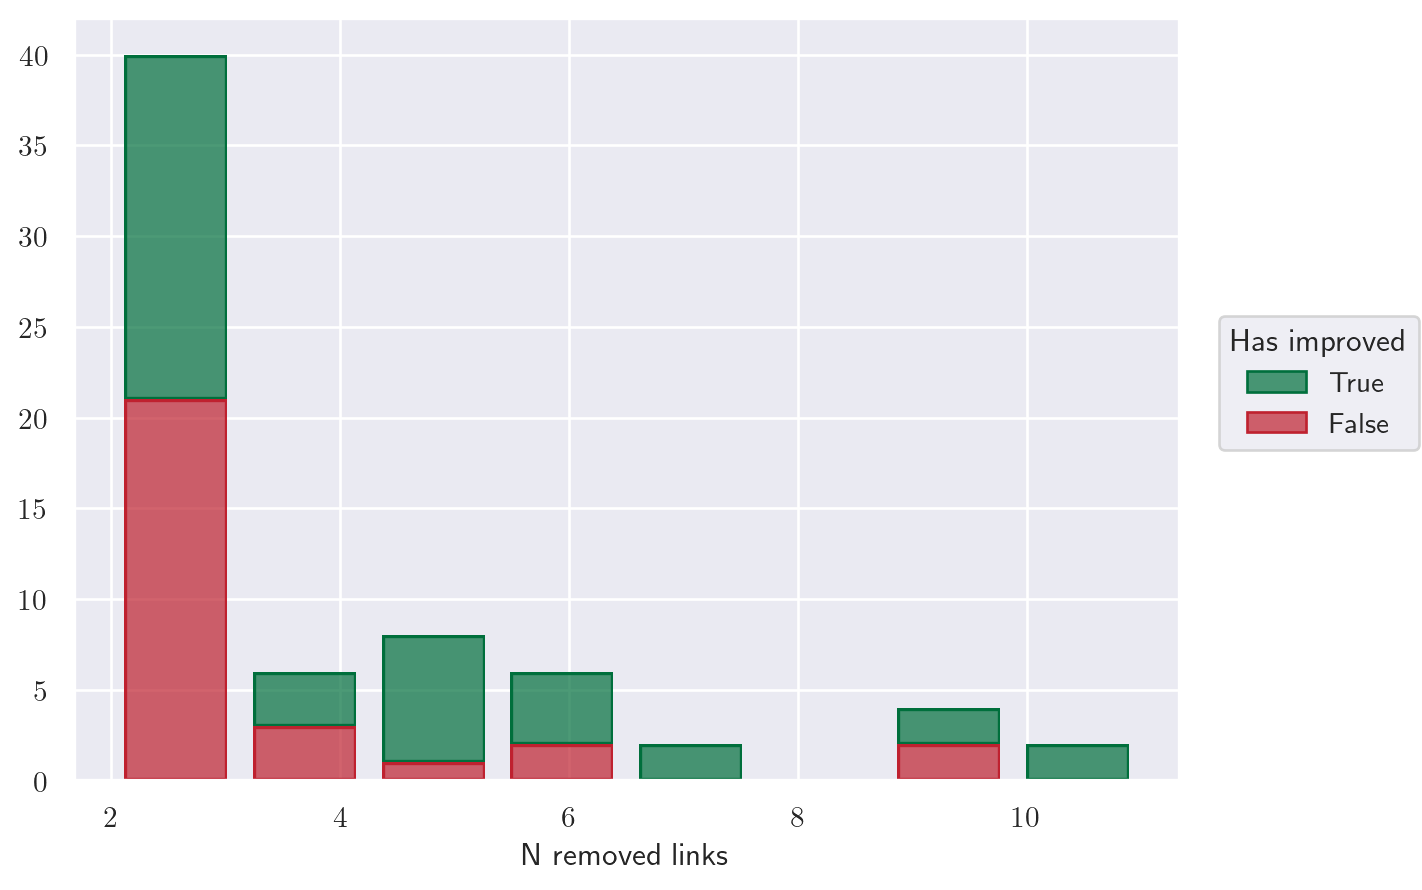

In [24]:
(
    so.Plot(data=df, color="Has improved", x="N removed links")
    .scale(color="blend:#006f3c,#bf212f")
    .add(so.Bar(), so.Hist(), so.Stack())
)

#### OD UE flows on banned links

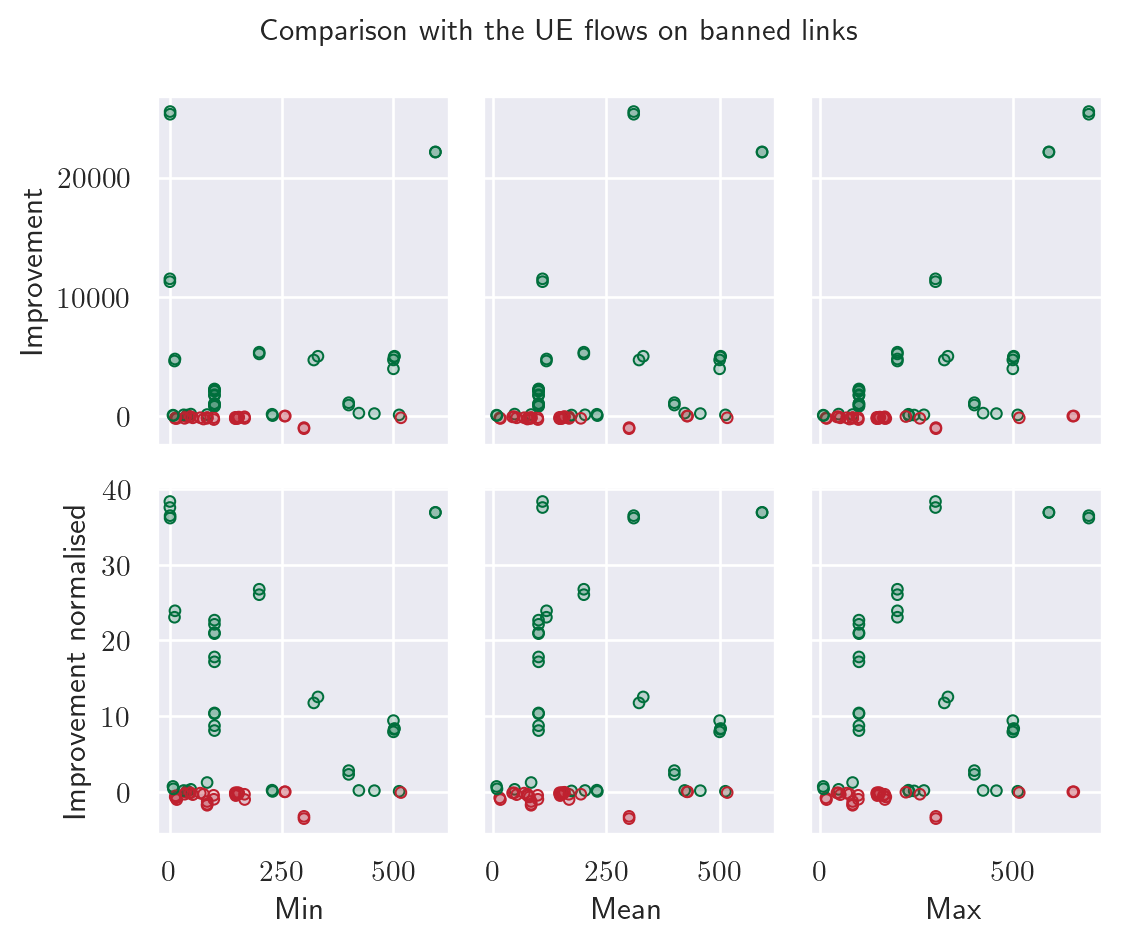

In [25]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['min_UE_flow_on_banned_links', 'mean_UE_flow_on_banned_links', 'max_UE_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .layout(size=(6,5))
    .add(so.Dots(), legend=False)
    .plot()
)
p._figure.suptitle("Comparison with the UE flows on banned links")
p.save("figs/results/UE_flow_ban.pgf", bbox_inches="tight")

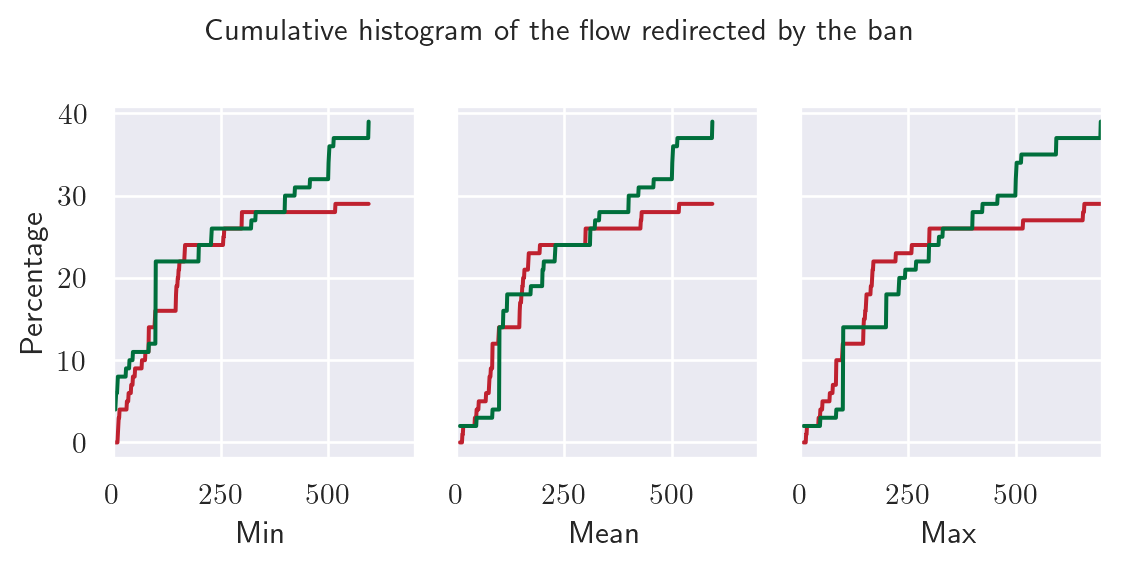

In [26]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_UE_flow_on_banned_links', 'mean_UE_flow_on_banned_links', 'max_UE_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max", y="Percentage")
    .share(x=True)
    .limit(x=(0, 700))
    .layout(size=(6,3))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=1), legend=False)
    .plot()
)
p._figure.suptitle("Cumulative histogram of the flow redirected by the ban")
p.save("figs/results/cumulative.pgf", bbox_inches = "tight")

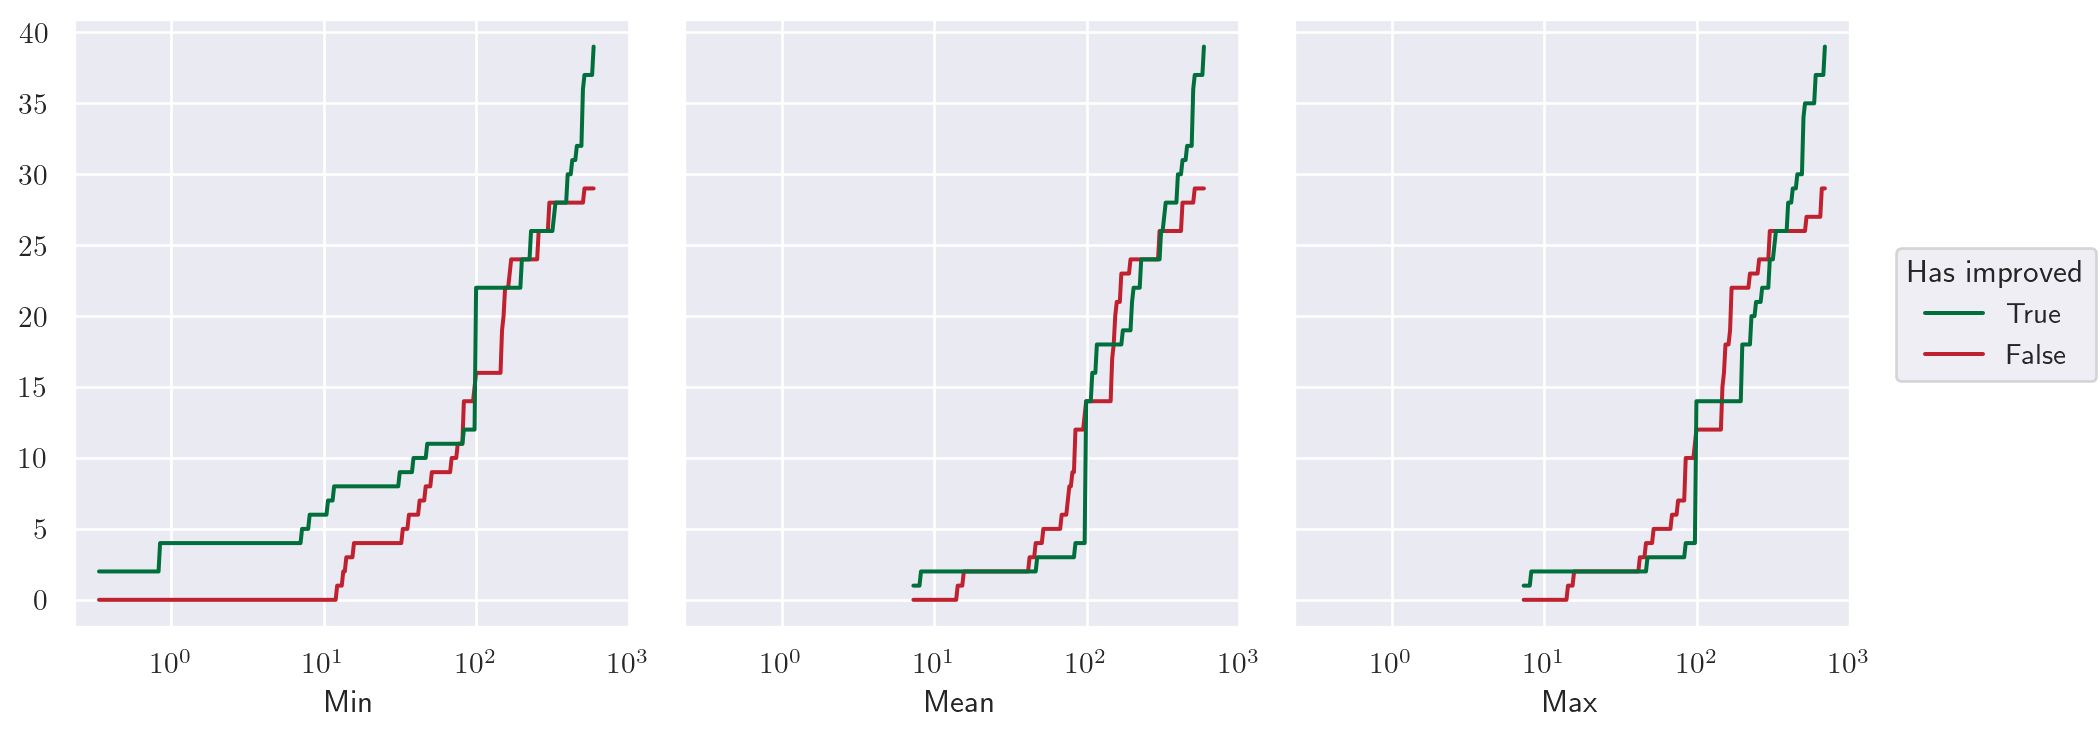

In [27]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_UE_flow_on_banned_links', 'mean_UE_flow_on_banned_links', 'max_UE_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f", x="log")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,4))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=0.01))
)

#### Paths impacted

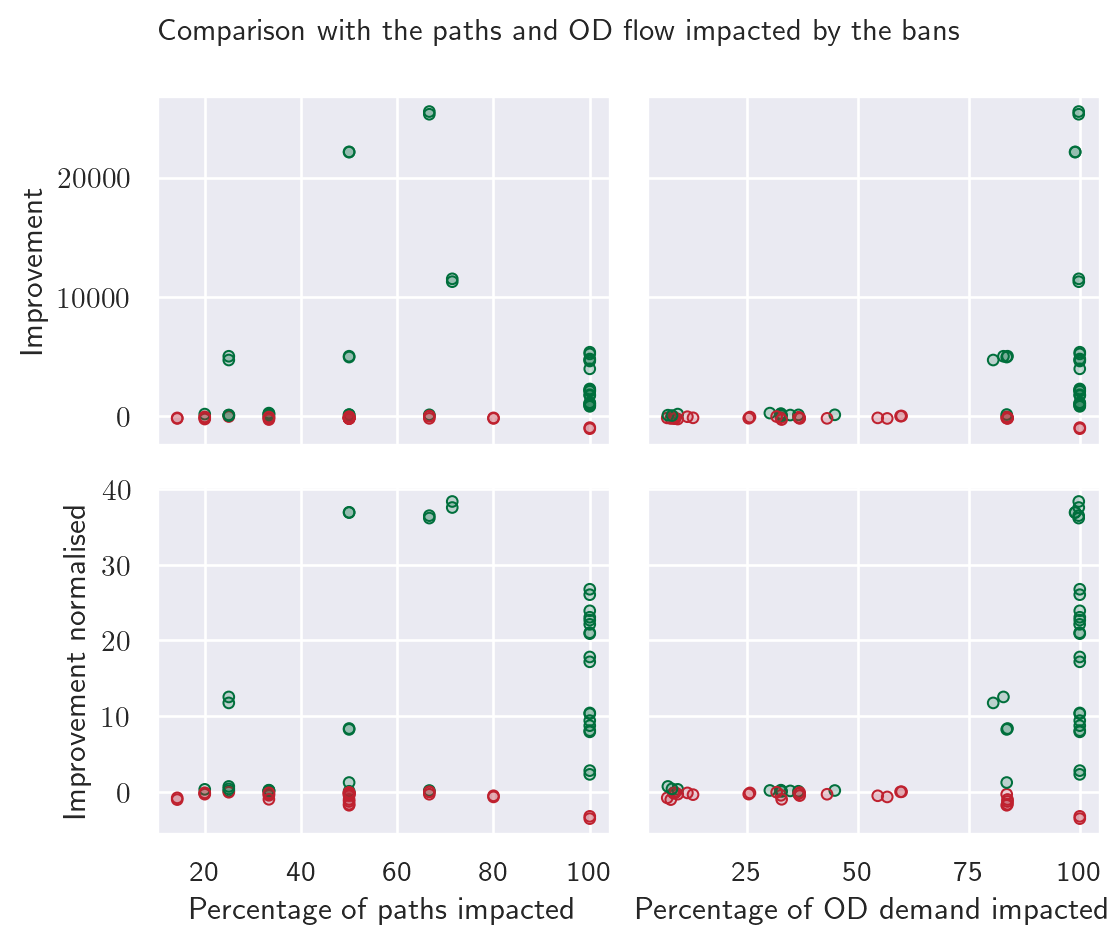

In [28]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['percentage_OD_paths_impacted', 'percentage_OD_demand_impacted'])
    .scale(color="blend:#006f3c,#bf212f", x=so.Continuous().label(like = lambda x, pos: f"{x*100:.0f} %"))
    .layout(size=(6,5))
    .add(so.Dots(), legend=False)
    .label(x0 = "Percentage of paths impacted", x1 = "Percentage of OD demand impacted")
    .plot()
)
p._figure.suptitle("Comparison with the paths and OD flow impacted by the bans")
p.save("figs/results/percentage_paths_flow.pgf", bbox_inches="tight")

#### Betweeness centrality

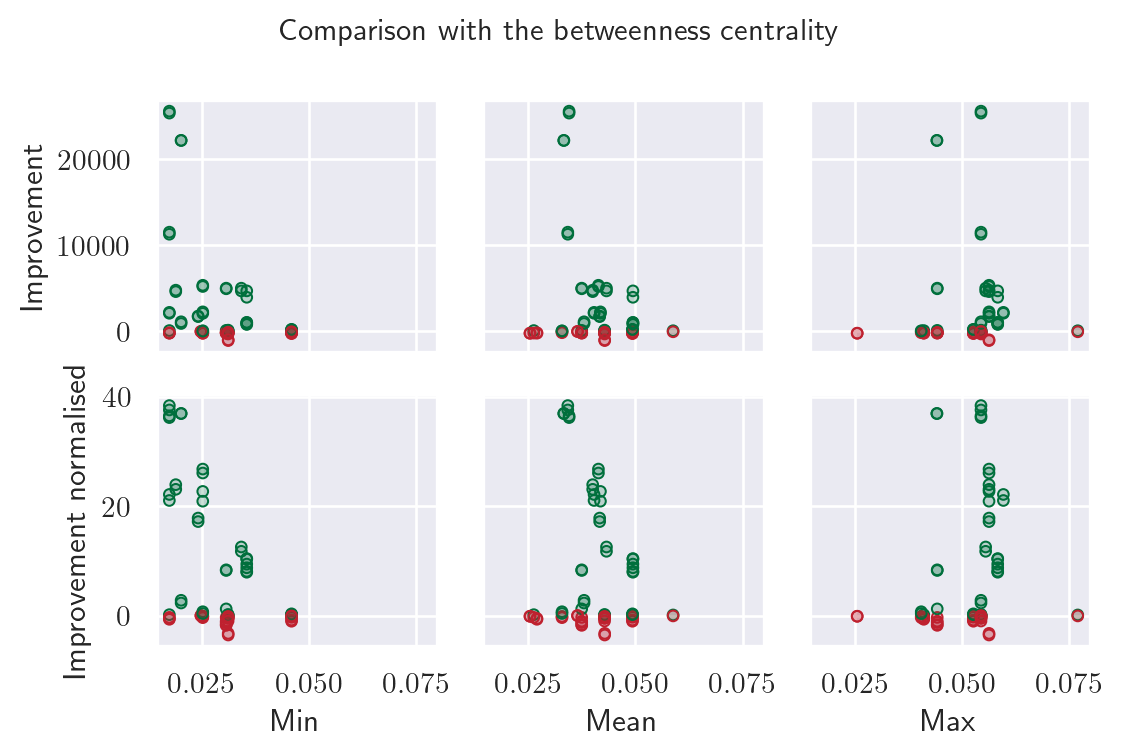

In [29]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['min_betweenness_centrality', 'mean_betweenness_centrality', 'max_betweenness_centrality'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x = True)
    .layout(size=(6,4))
    .add(so.Dots(), legend=False)
    .plot()
)
p._figure.suptitle("Comparison with the betweenness centrality")
p.save("figs/results/betweenness_centrality.pgf", bbox_inches="tight")

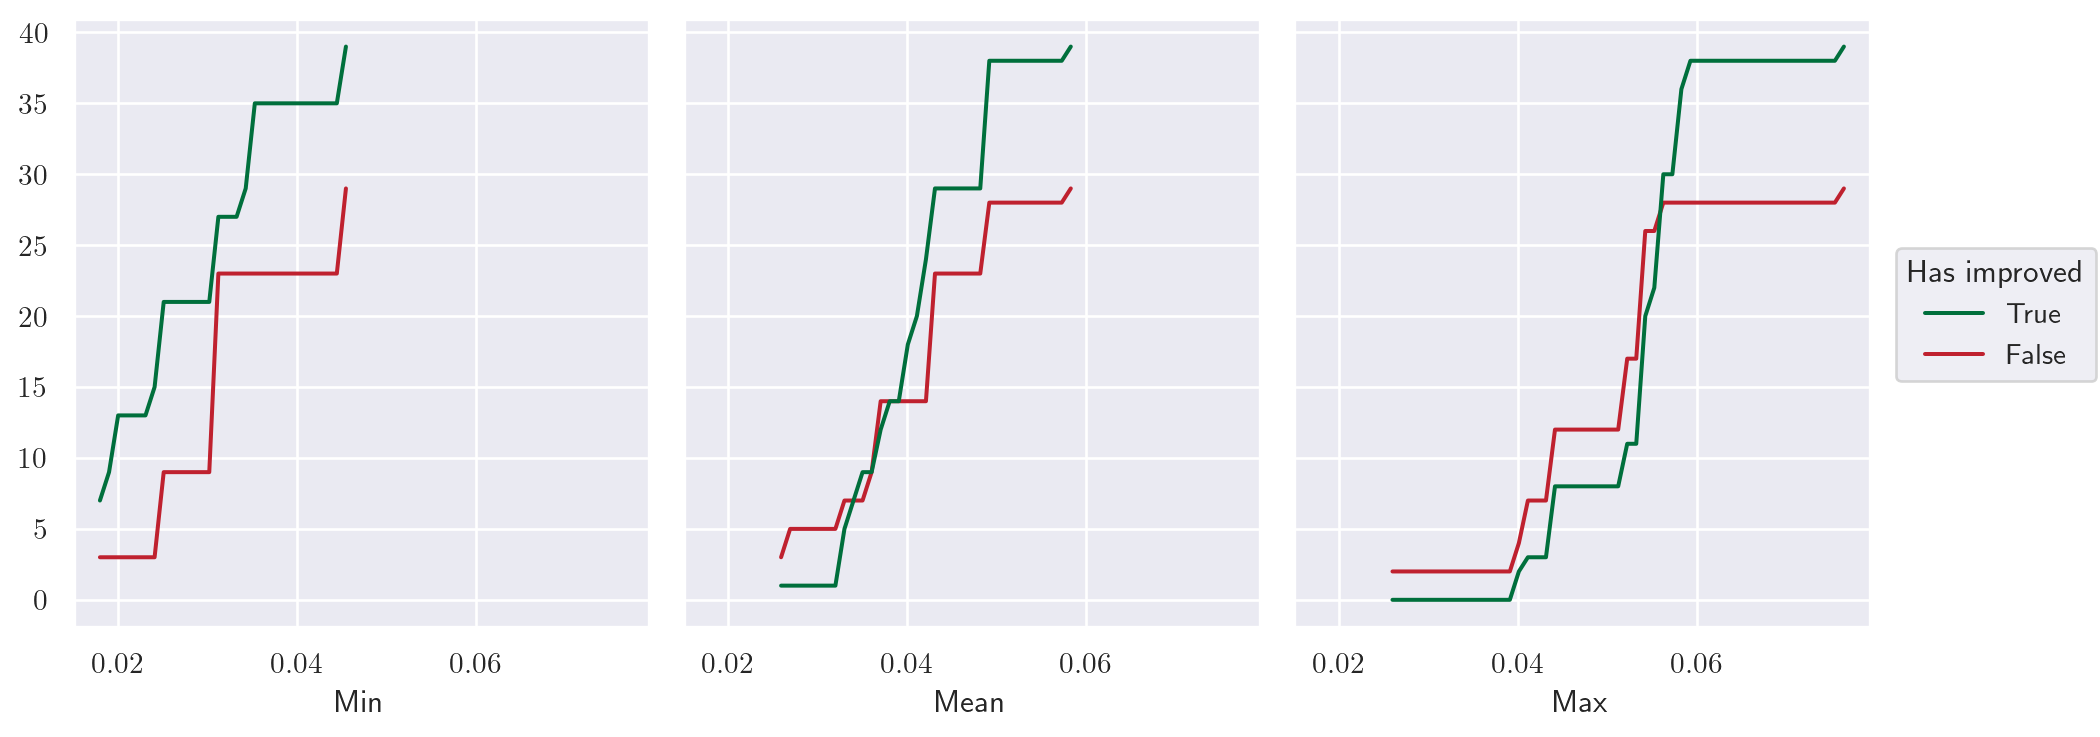

In [30]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_betweenness_centrality', 'mean_betweenness_centrality', 'max_betweenness_centrality'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,4))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=0.001))
)

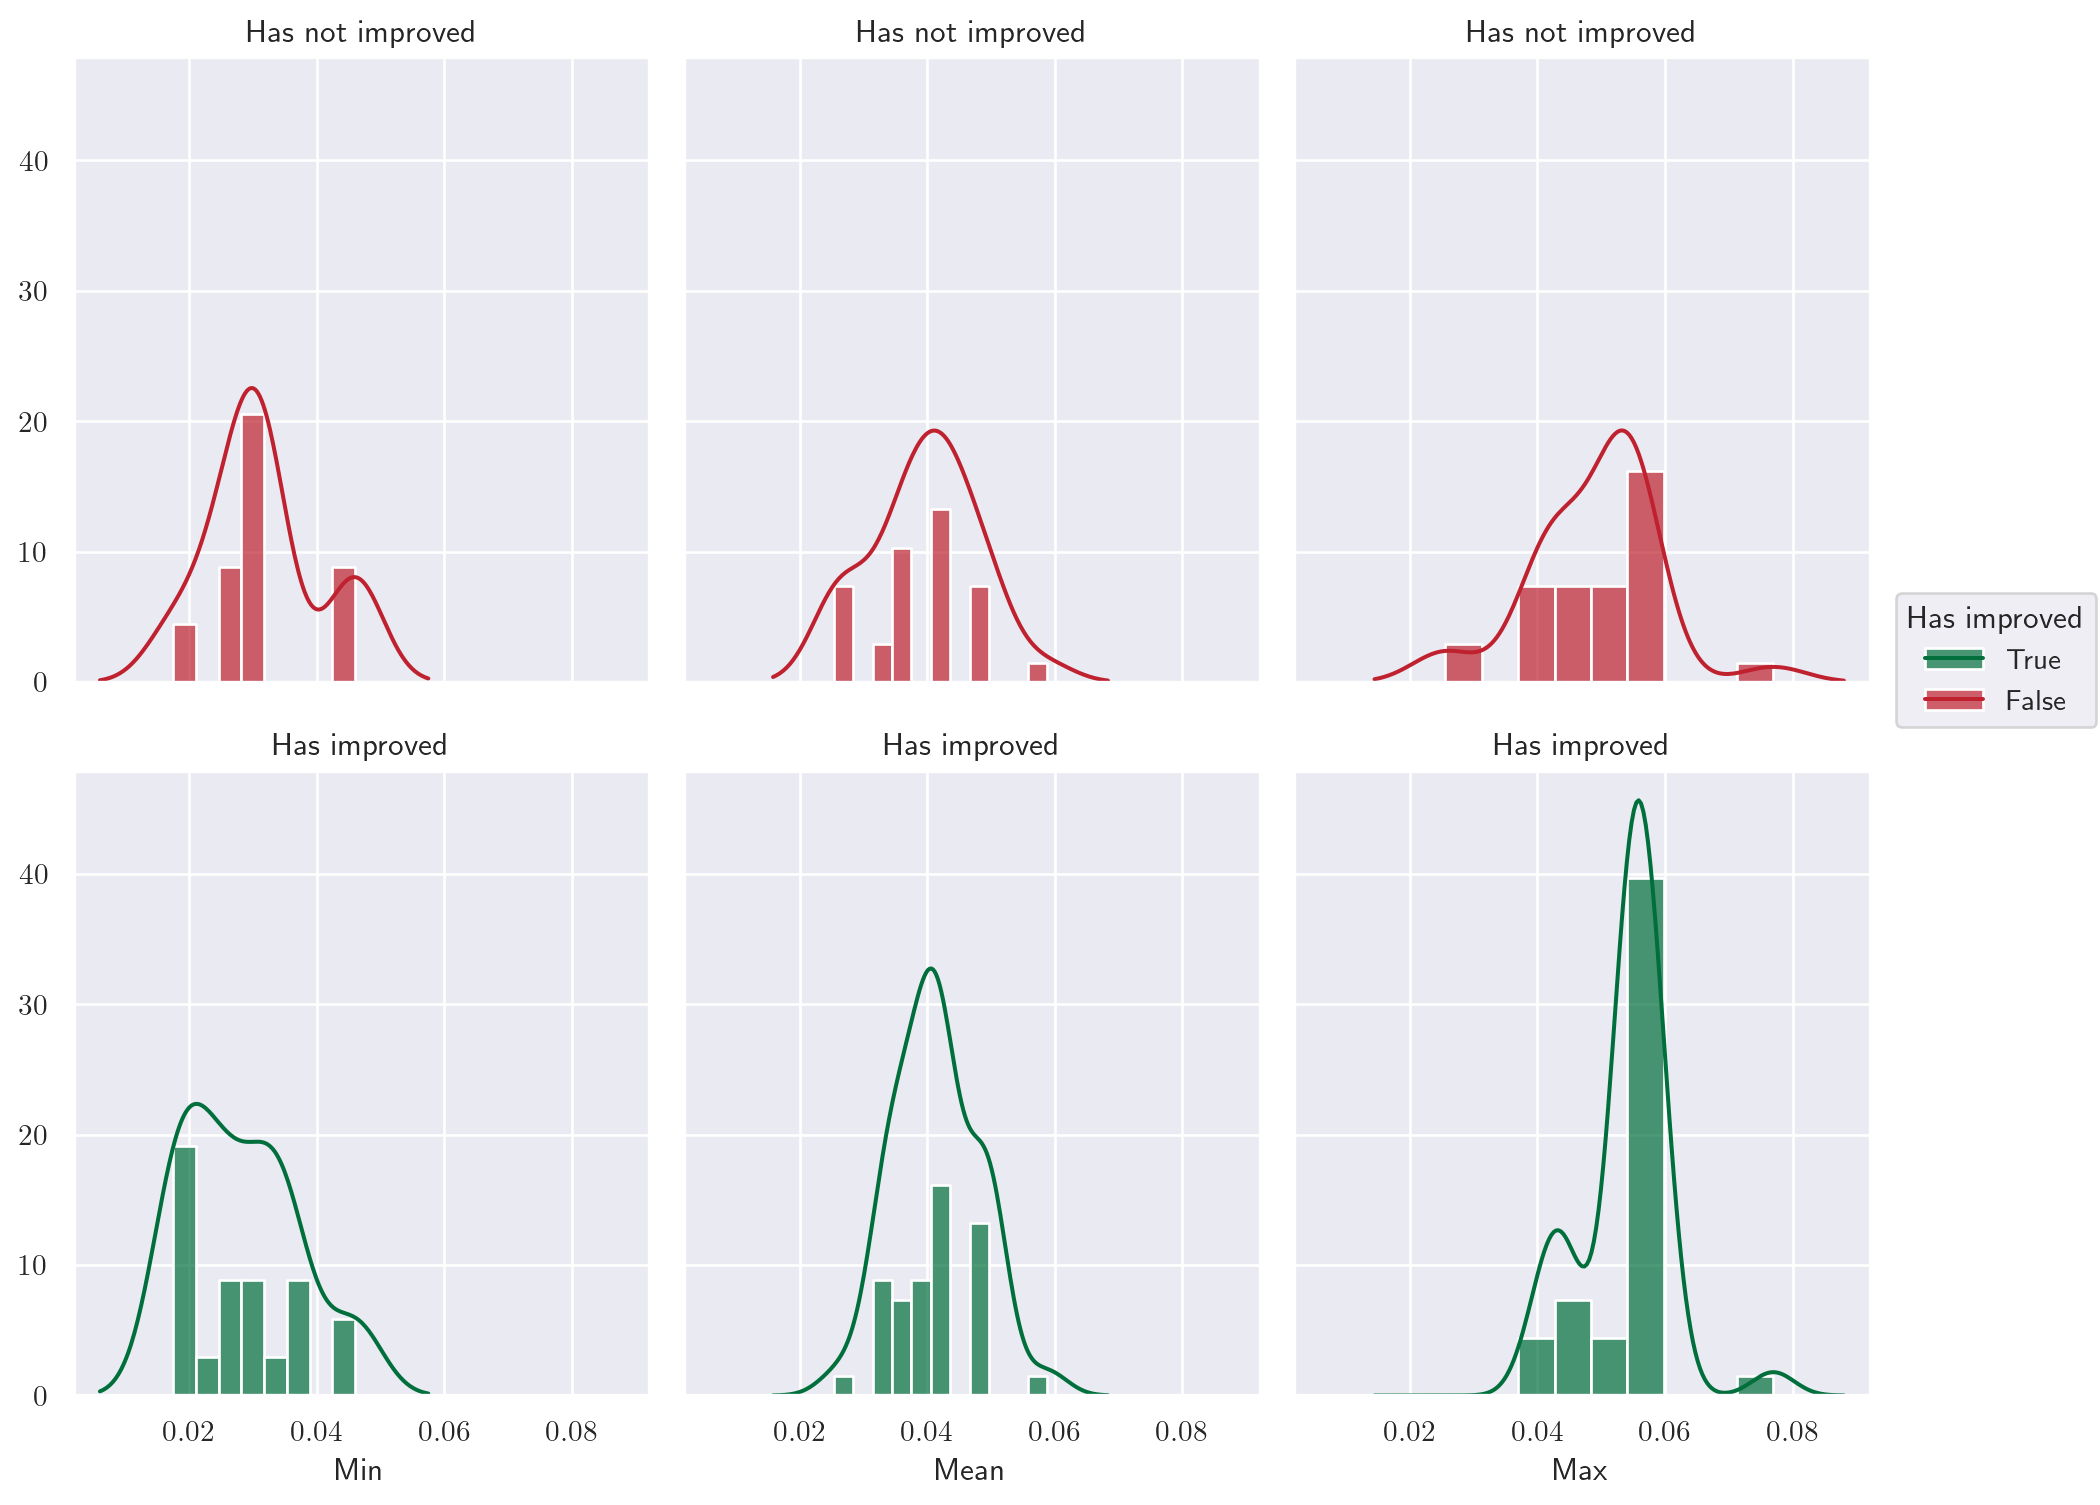

In [31]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_betweenness_centrality', 'mean_betweenness_centrality', 'max_betweenness_centrality'])
    .facet(row=df["Has improved"].apply(lambda x : "Has improved" if x else "Has not improved"))
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,8))
    .add(so.Bars(), so.Hist("percent"))
    .add(so.Line(), so.KDE())
)

#### Total flow on impacted links

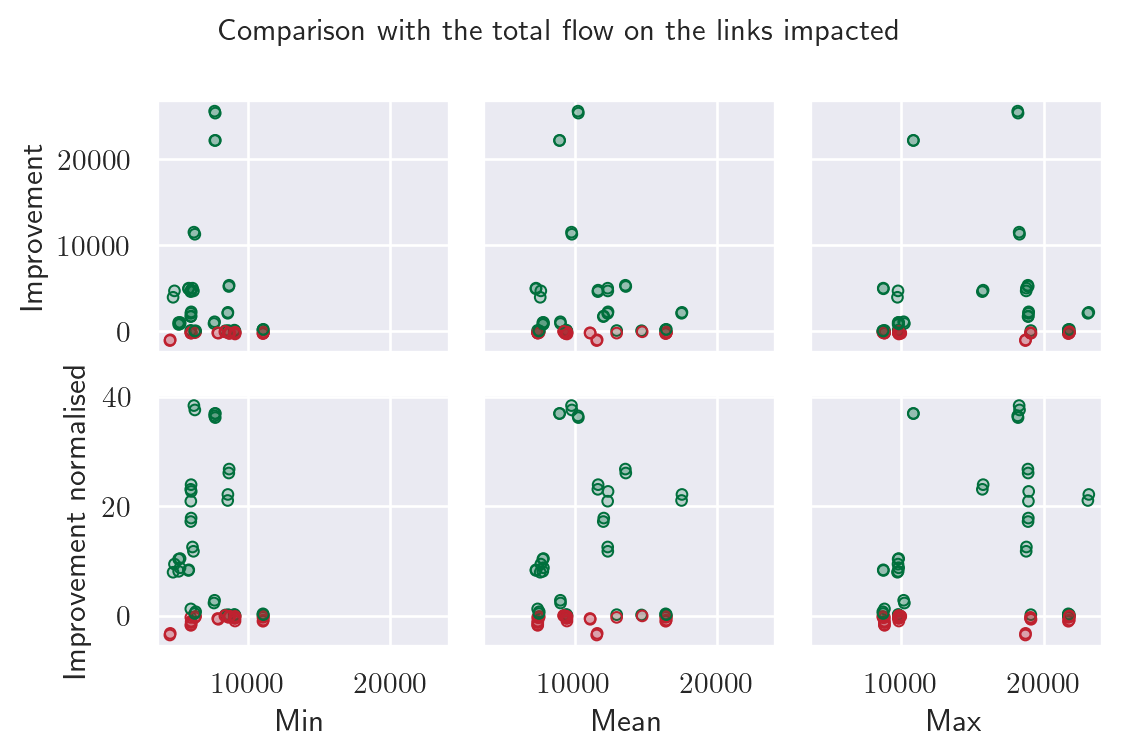

In [32]:
p = (
    so.Plot(data=df, color="Has improved")
    .pair(y = ["Improvement", "Improvement normalised"], x = ['min_total_flow_on_banned_links', 'mean_total_flow_on_banned_links', 'max_total_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x = True)
    .layout(size=(6,4))
    .add(so.Dots(), legend=False)
    .plot()
)
p._figure.suptitle("Comparison with the total flow on the links impacted")
p.save("figs/results/total_flow.pgf", bbox_inches= "tight")

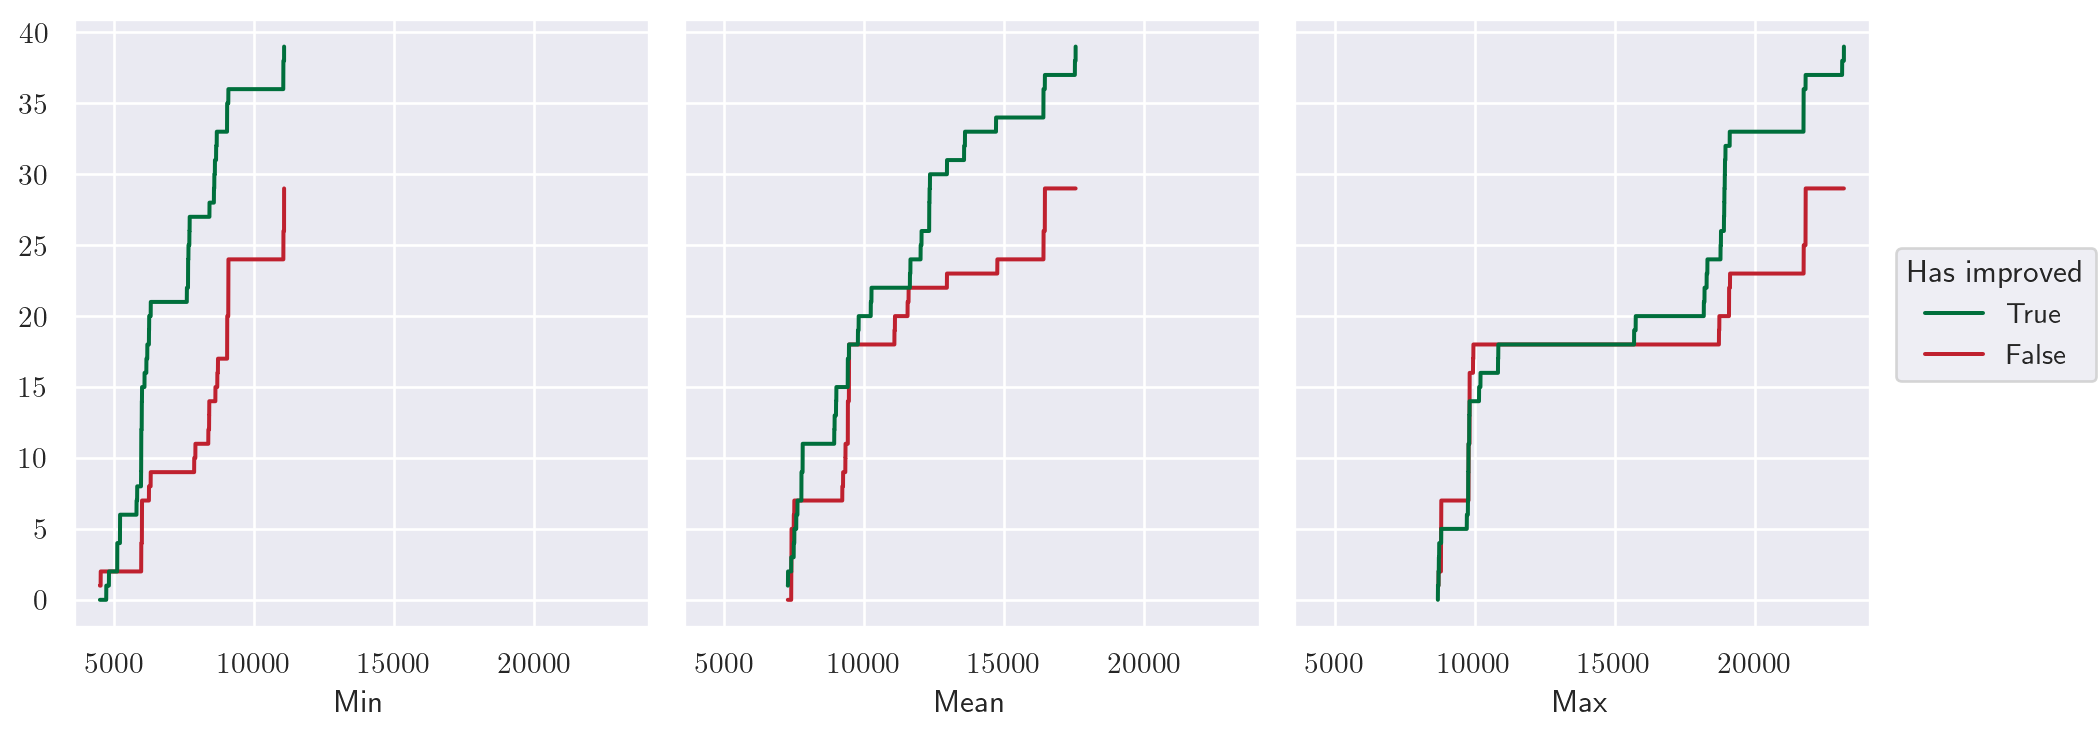

In [33]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_total_flow_on_banned_links', 'mean_total_flow_on_banned_links', 'max_total_flow_on_banned_links'])
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,4))
    .add(so.Line(), so.Hist("count", cumulative=True, common_norm=False, binwidth=1))
)

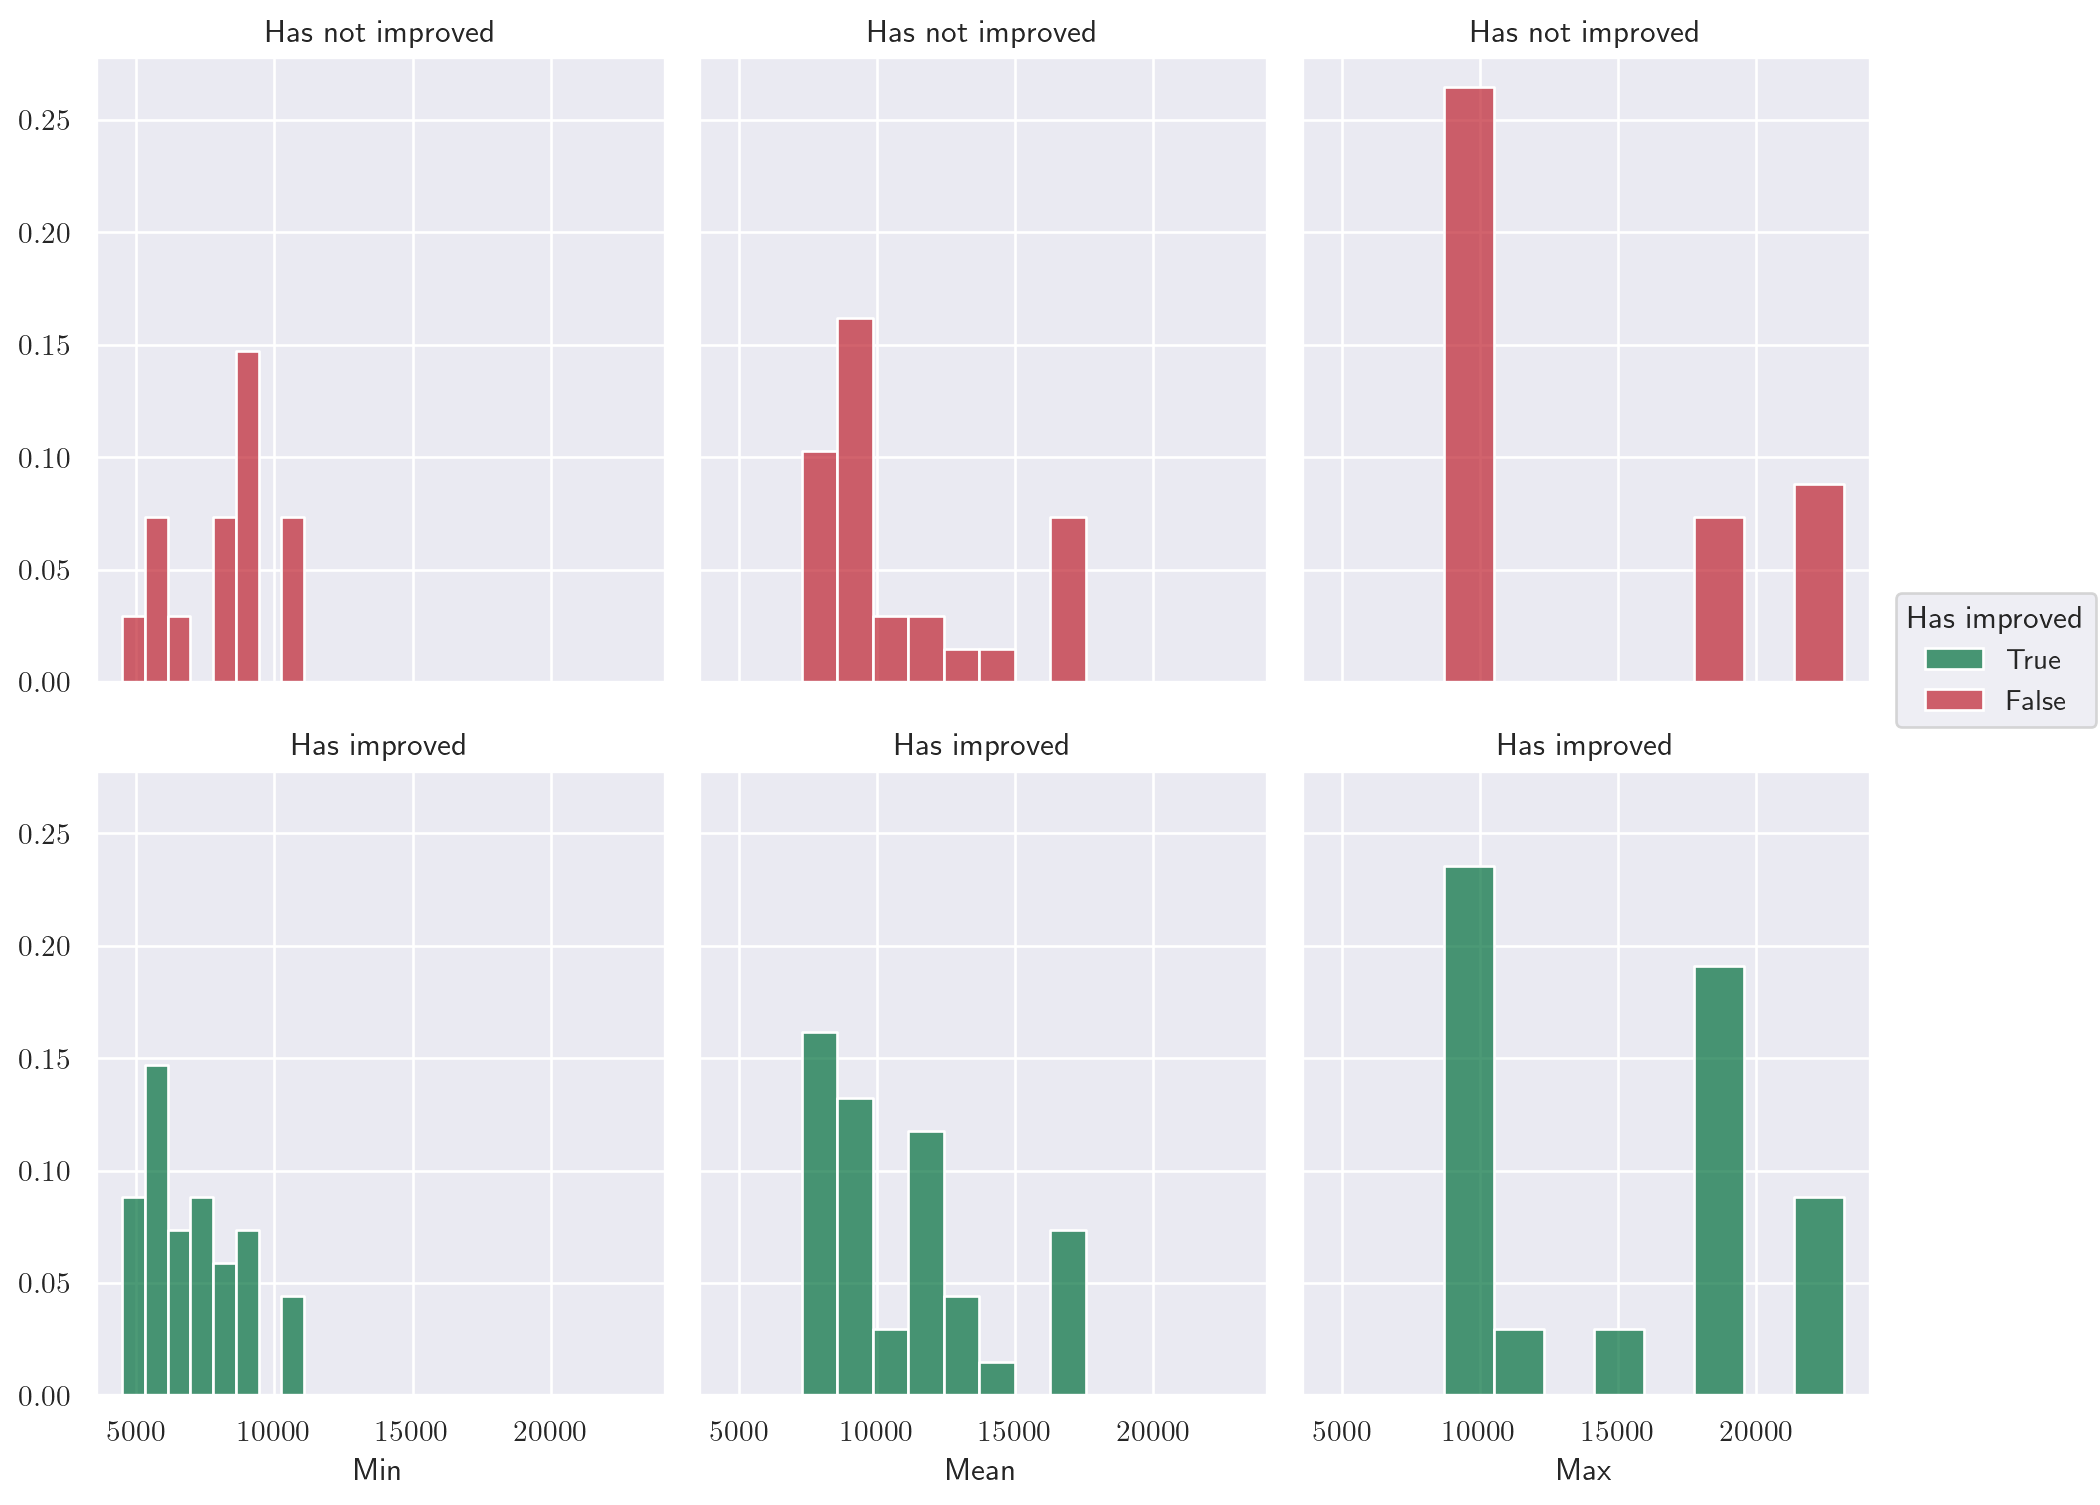

In [34]:
(
    so.Plot(data=df, color="Has improved")
    .pair( x = ['min_total_flow_on_banned_links', 'mean_total_flow_on_banned_links', 'max_total_flow_on_banned_links'])
    .facet(row=df["Has improved"].apply(lambda x : "Has improved" if x else "Has not improved"))
    .scale(color="blend:#006f3c,#bf212f")
    .label(x0="Min", x1="Mean", x2="Max")
    .share(x=True)
    .layout(size=(10,8))
    .add(so.Bars(), so.Hist("proportion"))
    #.add(so.Line(), so.KDE())
)

### After banning most common links to all OD

In [35]:
# Now, analyse results when banning links for the whole network
flows = net.load_flow(f"fw_p4", folder="files/precision", dim=1)
original_ttt = float(compute_total_travel_time(net, flows))
print("original total travel time :", original_ttt)
records = {}
for link in tqdm(OD_per_links[OD_per_links>0].dropna(axis=1).sort_values("Number of ODs", axis = 1, ascending= False).columns):
    try:
        flows = net.load_flow(f"n1_l{link-1}", dim=1, folder="files/masked")
        ttt = compute_total_travel_time(net, flows)
        records[link] = {
            "Total travel time": float(ttt),
            "Improvement": original_ttt - float(ttt),
            "UE_flows_on_banned_link": UE_OD_flows[:, :, link-1].sum(),
            "min_UE_flow_on_banned_link" : UE_OD_flows[:, :, link-1].min(),
            "max_UE_flow_on_banned_link" : UE_OD_flows[:, :, link-1].max(),
            "Has improved": bool((original_ttt - float(ttt))>0)
        }
    except ValueError:
        print(f"Link {link} not found")
df2 = pd.DataFrame.from_dict(records, orient="index")
df2.index.set_names(["Link banned"], inplace=True)
df2

original total travel time : 7479625.830083258


100%|██████████| 62/62 [00:00<00:00, 666.77it/s]

[('SiouxFalls', 'n1_l14'), ('SiouxFalls', 'o23d16'), ('SiouxFalls', 'n1_l25'), ('SiouxFalls', 'o14d1'), ('SiouxFalls', 'o20d18'), ('SiouxFalls', 'o18d5'), ('SiouxFalls', 'o11d18'), ('SiouxFalls', 'o1d18'), ('SiouxFalls', 'o18d20'), ('SiouxFalls', 'o19d0'), ('SiouxFalls', 'n1_l58'), ('SiouxFalls', 'o18d11'), ('SiouxFalls', 'n1_l71'), ('SiouxFalls', 'o18d10'), ('SiouxFalls', 'o23d18'), ('SiouxFalls', 'o18d23'), ('SiouxFalls', 'n1_l67'), ('SiouxFalls', 'n1_l25'), ('SiouxFalls', 'o12d18'), ('SiouxFalls', 'n1_l61'), ('SiouxFalls', 'o19d0'), ('SiouxFalls', 'o18d12'), ('SiouxFalls', 'n1_l1'), ('SiouxFalls', 'o1d14'), ('SiouxFalls', 'n1_l44'), ('SiouxFalls', 'o12d18'), ('SiouxFalls', 'n1_l65'), ('SiouxFalls', 'n1_l34'), ('SiouxFalls', 'o20d18'), ('SiouxFalls', 'o5d18'), ('SiouxFalls', 'n1_l61'), ('SiouxFalls', 'n1_l4'), ('SiouxFalls', 'o22d5'), ('SiouxFalls', 'o6d12'), ('SiouxFalls', 'n1_l18'), ('SiouxFalls', 'o1d8'), ('SiouxFalls', 'o15d11'), ('SiouxFalls', 'o15d4'), ('SiouxFalls', 'n1_l10'),

,Total travel time,Improvement,UE_flows_on_banned_link,min_UE_flow_on_banned_link,max_UE_flow_on_banned_link,Has improved
Link banned,,,,,,
34,8.405542e+06,-9.259166e+05,9776.121895,0.0,1600.000000,False
40,8.412102e+06,-9.324759e+05,9814.056785,0.0,1600.000000,False
41,8.078480e+06,-5.988540e+05,9036.292997,0.0,1300.000000,False
42,7.926255e+06,-4.466294e+05,8400.375150,0.0,1300.000000,False
71,7.924018e+06,-4.443922e+05,8394.837234,0.0,1300.000000,False
44,8.085939e+06,-6.063136e+05,9079.770228,0.0,1300.000000,False
59,7.891506e+06,-4.118798e+05,8688.311432,0.0,1475.423531,False
61,7.891479e+06,-4.118536e+05,8710.591472,0.0,1478.837338,False
4,7.724969e+06,-2.453433e+05,5967.321687,0.0,800.000000,False


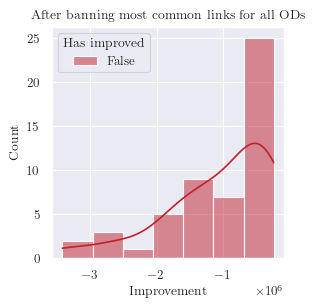

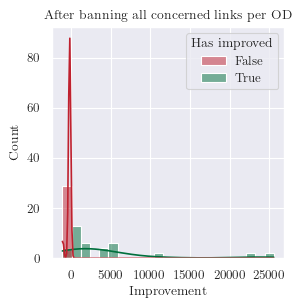

In [36]:
sns.histplot(data=df2, x="Improvement", hue="Has improved", palette="blend:#bf212f,#006f3c", kde=True)
plt.title("After banning most common links for all ODs")
plt.gcf().set_size_inches(3, 3)
plt.savefig("figs/results/banning_all_OD.pgf", bbox_inches="tight")
plt.show()
sns.histplot(data=df, x="Improvement", hue="Has improved", palette="blend:#bf212f,#006f3c", kde=True)
plt.title("After banning all concerned links per OD")
plt.gcf().set_size_inches(3, 3)
plt.savefig("figs/results/banning_1_OD.pgf", bbox_inches="tight")
plt.show()